In [656]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import random
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, precision_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

In [541]:
pd.set_option('display.max_columns', None)
np.random.seed(1973) 

In [542]:
# df = pd.read_csv(r"C:\Users\xtaym\OneDrive\Pulpit\mgr\cell2celltrain.csv")
# holdout_innit = pd.read_csv(r""C:\Users\xtaym\OneDrive\Pulpit\cell2cell-duke univeristy.csv"mgr\cell2cellholdout.csv")
df=pd.read_csv(r'C:\Users\xtaym\OneDrive\Pulpit\cell2cell-duke univeristy.csv')

# holdout set will not be used as it was not scored
df 

,Unnamed: 0,X,customer,traintest,churn,churndep,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
0,1,1,1000002,0,0,NaN,57.492500,482.75,37.424999,0.2475,22.75,0.0,532.25,50.987499,8.333333,1.000000,61.333332,1.666667,0.333333,55.279999,46.333332,6.333333,83.666664,157.000000,9.333333,0.0,5.666667,56,1,1,7.0,6.0,240.0,30.0,0.0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,0,5,0,0,149.989990,0
1,2,2,1000006,0,0,NaN,82.275002,1312.25,75.000000,1.2375,0.00,0.0,156.75,8.145000,52.000000,7.666667,76.000000,4.333333,1.333333,200.320007,370.333344,147.000000,555.666687,303.666656,59.666668,0.0,22.666666,59,2,2,9.0,4.0,458.0,30.0,0.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,6,0,0,9.989998,0
2,3,3,1000010,0,0,NaN,31.662500,25.50,29.990000,0.2475,0.00,0.0,59.50,4.027500,0.000000,1.000000,2.333333,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,1.666667,1.000000,0.0,0.000000,57,2,2,2.0,2.0,601.0,52.0,58.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,1,0,0,0,1,0,0,9,0,0,29.989990,0
3,4,4,1000011,0,0,NaN,62.127499,97.50,65.985001,2.4750,0.00,0.0,23.50,6.822500,0.000000,0.333333,4.000000,4.000000,0.000000,0.000000,3.666667,0.000000,7.666667,7.333333,0.333333,0.0,0.000000,59,2,2,3.0,3.0,464.0,46.0,46.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,6,0,0,29.989990,0
4,5,5,1000014,0,0,NaN,25.225000,2.50,25.000000,0.0000,0.00,0.0,-2.50,-0.225000,0.000000,0.000000,0.333333,0.000000,0.000000,1.133333,0.333333,0.000000,0.666667,0.666667,0.000000,0.0,0.000000,53,2,2,2.0,2.0,354.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,7,0,0,29.989990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71042,71043,71043,1099987,1,1,1.0,117.489998,384.00,29.990000,0.0000,250.00,0.0,0.00,0.000000,4.000000,1.000000,27.000000,0.000000,0.000000,21.703333,1.333333,0.000000,99.333336,54.333332,5.000000,0.0,0.000000,30,1,1,2.0,2.0,489.0,22.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,29.989990,0
71043,71044,71044,1099988,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.666667,0.000000,0.0,0.000000,25,1,1,1.0,1.0,773.0,34.0,26.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,6,0,1,0.000000,0
71044,71045,71045,1099990,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.333333,2.666667,48.333332,0.000000,0.000000,58.923332,17.000000,1.333333,160.333328,33.333332,12.000000,0.0,0.333333,29,1,1,2.0,2.0,526.0,68.0,64.0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,6,0,0,59.989990,0
71045,71046,71046,1099992,1,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.316667,0.666667,0.333333,5.333333,3.333333,0.000000,0.0,0.000000,25,1,1,1.0,1.0,773.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,8,0,1,0.000000,0


In [543]:
df=df.set_index('customer')
df=df.drop(columns=['X','Unnamed: 0'])

In [544]:
holdout_df=df[df['traintest']==0]
df=df.drop(holdout_df.index)

In [545]:
df=df.drop(columns=['traintest','churndep'])
holdout_df=holdout_df.drop(columns=['traintest','churndep'])

In [546]:
holdout_df.churn.value_counts()

churn
0    30438
1      609
Name: count, dtype: int64

In [547]:
df.churn.value_counts()

churn
0    20000
1    20000
Name: count, dtype: int64

# EDA

In [548]:
print(f'for test and training we have {len(df)} records and for holdout we have {len(holdout_df)} records, both data sets have {len(df.columns)} variables')

for test and training we have 40000 records and for holdout we have 31047 records, both data sets have 67 variables


In [549]:
df.head()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000004,0,38.000000,7.50,38.000000,0.0000,0.0,0.0,-1.50,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.413333,0.333333,0.000000,1.333333,3.666667,0.000000,0.0,0.000000,60,1,1,1.0,1.0,1812.0,26.0,26.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,6,0,1,0.000000,0
1000005,0,55.230000,570.50,71.980003,0.0000,0.0,0.0,38.50,0.000000,9.666667,0.666667,77.0,8.666667,0.000000,106.330002,14.666667,0.666667,97.333336,90.333336,10.333333,0.0,0.000000,57,1,1,6.0,4.0,434.0,56.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,6,0,0,79.989990,0
1000008,0,38.052502,682.50,52.490002,0.2475,0.0,0.0,147.50,-3.062500,9.000000,1.666667,13.0,0.666667,0.000000,42.196667,6.666667,0.000000,33.333332,53.000000,10.666667,0.0,0.666667,53,1,1,3.0,2.0,231.0,28.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,29.989990,0
1000009,0,97.337502,1039.00,50.000000,4.9500,419.5,0.0,198.00,23.262501,12.666667,3.000000,176.0,11.333333,0.333333,213.853332,103.333336,0.333333,238.333328,192.333328,15.666667,0.0,4.000000,55,1,1,3.0,3.0,700.0,38.0,24.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,9.989998,0
1000012,0,35.294998,24.25,34.980000,0.0000,0.0,0.0,19.75,-0.315000,0.000000,0.000000,1.0,0.000000,0.000000,2.386667,4.000000,1.666667,9.333333,1.666667,0.000000,0.0,0.000000,53,3,3,4.0,3.0,544.0,36.0,34.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,9,0,0,79.989990,0


In [550]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 1000004 to 1099995
Data columns (total 67 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   churn     40000 non-null  int64  
 1   revenue   39859 non-null  float64
 2   mou       39859 non-null  float64
 3   recchrge  39859 non-null  float64
 4   directas  39859 non-null  float64
 5   overage   39859 non-null  float64
 6   roam      39859 non-null  float64
 7   changem   39639 non-null  float64
 8   changer   39639 non-null  float64
 9   dropvce   40000 non-null  float64
 10  blckvce   40000 non-null  float64
 11  unansvce  40000 non-null  float64
 12  custcare  40000 non-null  float64
 13  threeway  40000 non-null  float64
 14  mourec    40000 non-null  float64
 15  outcalls  40000 non-null  float64
 16  incalls   40000 non-null  float64
 17  peakvce   40000 non-null  float64
 18  opeakvce  40000 non-null  float64
 19  dropblk   40000 non-null  float64
 20  callfwdv  40000 non-null 

In [551]:
df.describe()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
count,40000.000000,39859.000000,39859.00000,39859.000000,39859.000000,39859.000000,39859.000000,39639.000000,39639.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,39294.000000,39294.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.500000,58.632643,513.97351,46.271960,0.878711,40.863133,1.228694,-15.006928,-0.939337,5.940213,4.030525,27.771762,1.778229,0.284450,112.157275,24.836208,7.993717,88.685446,66.074488,10.046646,0.009167,1.790696,18.831750,1.551675,1.35925,1.788325,1.543400,392.839500,31.062427,21.016746,0.244325,0.101700,0.11815,0.049800,0.318825,0.149300,0.144725,0.894900,0.187400,0.081625,0.173550,0.020025,0.029150,0.007300,0.003025,0.014225,0.017850,0.335125,0.388350,0.365325,0.357225,0.372425,0.015075,0.057075,0.185325,0.675825,0.044025,0.020425,0.193100,0.140600,0.047850,0.252650,4.330900,0.013950,0.575925,34.976005,0.040425
std,0.500006,44.142432,524.75989,23.714145,2.072555,98.272111,8.329852,259.646507,39.760781,8.880774,10.495103,38.250252,5.175107,1.074865,165.082658,34.764911,16.611850,102.933661,91.916943,15.348324,0.472957,5.375079,9.624604,1.314600,0.68480,1.319891,0.893553,256.715982,22.057552,23.810636,0.429692,0.302257,0.32279,0.217534,0.466027,0.356388,0.351828,0.306686,0.390237,0.273796,0.378727,0.140087,0.168229,0.085129,0.054917,0.118419,0.132408,0.472040,0.487381,0.481527,0.479188,0.483457,0.121853,0.231989,0.388566,0.468072,0.224584,0.150693,0.394736,0.347613,0.249223,0.434537,3.144329,0.117285,0.494208,56.620460,0.196956
min,0.000000,-5.862500,0.00000,-11.290000,0.000000,0.000000,0.000000,-2867.500000,-851.104981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.00000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.367500,151.25000,30.000000,0.000000,0.000000,0.000000,-87.500000,-7.140000,0.666667,0.000000,5.000000,0.000000,0.000000,7.606667,3.000000,0.000000,21.666666,10.333333,1.666667,0.000000,0.000000,11.000000,1.000000,1.00000,1.000000,1.000000,212.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,48.365002,356.50000,44.990002,0.247500,2.750000,0.000000,-6.250000,-0.292500,3.000000,1.000000,16.000000,0.

In [552]:
df.shape

(40000, 67)

## DEP VARIABLE

In [553]:
holdout_df['churn'].value_counts()

churn
0    30438
1      609
Name: count, dtype: int64

In [554]:
holdout_df.describe()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
count,31047.000000,30972.000000,30972.000000,30972.000000,30972.000000,30972.000000,30972.000000,30906.000000,30906.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31046.000000,31046.000000,31046.000000,30509.000000,30509.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.000000,31047.00000
mean,0.019615,59.136135,540.856181,47.654058,0.913738,39.107286,1.211261,-5.510385,-1.547178,6.099838,4.115900,29.108491,1.978892,0.320417,118.514481,26.118423,8.412675,93.023051,70.065245,10.282572,0.015278,1.933348,18.646568,1.501047,1.341869,1.834761,1.585486,364.065322,31.777836,21.339277,0.239894,0.107965,0.141785,0.045093,0.324057,0.147293,0.133024,0.913003,0.186975,0.080652,0.174349,0.020099,0.030277,0.007923,0.003318,0.014881,0.017812,0.327793,0.380262,0.365446,0.368087,0.383354,0.013560,0.058009,0.185525,0.677199,0.027958,0.014687,0.192740,0.136438,0.054723,0.246207,4.338519,0.012819,0.554385,36.858361,0.02580
std,0.138677,44.372524,536.601264,24.149383,2.348869,93.803961,9.965018,249.550642,37.459479,9.164456,10.892934,39.718928,5.140100,1.264254,167.803240,35.621960,16.395990,107.365881,95.071674,15.603264,0.659580,5.780292,9.992800,0.838612,0.626597,1.356318,0.926387,250.214987,22.107739,24.053803,0.427026,0.310342,0.348835,0.207511,0.468029,0.354403,0.339606,0.281835,0.389897,0.272304,0.379415,0.140340,0.171350,0.088662,0.057503,0.121077,0.132269,0.469417,0.485459,0.481563,0.482293,0.486211,0.115657,0.233764,0.388729,0.467555,0.178368,0.128583,0.394457,0.343259,0.336146,0.430808,3.127723,0.112496,0.497041,57.561782,0.15854
min,0.000000,-6.167500,0.000000,-8.710000,0.000000,0.000000,0.000000,-3875.000000,-1107.739990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.000000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,33.990002,168.000000,30.000000,0.000000,0.000000,0.000000,-77.500000,-7.046875,1.000000,0.000000,5.666667,0.000000,0.000000,9.638333,3.666667,0.000000,24.666666,12.000000,2.000000,0.000000,0.000000,11.000000,1.000000,1.000000,1.000000,1.000000,197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,48.742500,377.500000,44.990002,0.247500,2.500000,0.000000,-3.250000,-0.315000,3.000000,1.000000,16

<Axes: xlabel='churn', ylabel='Count'>

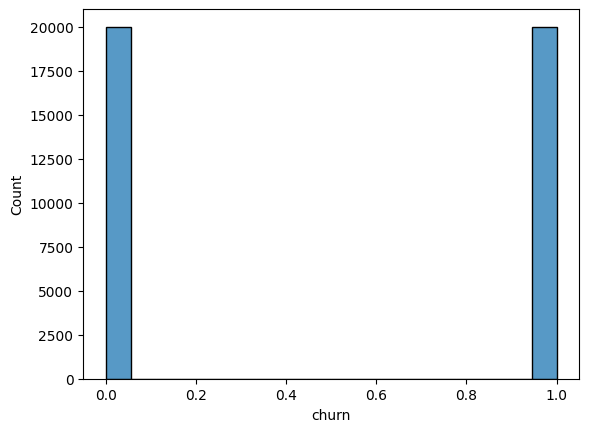

In [555]:
sns.histplot(df['churn'])

## FEATURES

In [556]:
def transform_binary_to_categorical(df_temp, binary_columns, new_col_name='def'):
    # Initialize the new categorical column with NaN
    df_temp[new_col_name] = np.nan
    
    for col in binary_columns:
        # Update the new column with the column name where the binary value is 1
        df_temp.loc[df[col] == 1, new_col_name] = col
        df_temp[new_col_name]=df_temp[new_col_name].fillna('other')
    # Optionally, you can drop the original binary columns
    df_temp.drop(columns=binary_columns, inplace=True)
    
    return df_temp

In [557]:
occ_cols=['occprof',
'occcler',
'occcrft',
'occstud',
'occhmkr',
'occret',
'occself']

In [558]:
prizm_cols=['prizmrur',
'prizmub',
'prizmtwn']

In [559]:
credit_cols=['credita',
'creditaa']

In [560]:
mail_cols=['mailord',
'mailres',
'mailflag']

In [561]:
martial_cols=['marryun',
'marryyes']

In [562]:
celusr_cols=['newcelly',
'newcelln']

In [563]:
df_exp=df.copy()

In [564]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=occ_cols,new_col_name='occupation')

In [565]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=prizm_cols,new_col_name='location')

In [566]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=credit_cols,new_col_name='credit')

In [567]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=mail_cols,new_col_name='mailstatus')

In [568]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=martial_cols,new_col_name='martial')

In [569]:
df_exp=transform_binary_to_categorical(df_exp,binary_columns=celusr_cols,new_col_name='cell_user_type')

In [570]:
df_exp.head()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,refurb,webcap,truck,rv,ownrent,travel,pcown,creditcd,retcalls,retaccpt,refer,incmiss,income,mcycle,setprcm,setprc,retcall,occupation,location,credit,mailstatus,martial,cell_user_type
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000004,0,38.000000,7.50,38.000000,0.0000,0.0,0.0,-1.50,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.413333,0.333333,0.000000,1.333333,3.666667,0.000000,0.0,0.000000,60,1,1,1.0,1.0,1812.0,26.0,26.0,1,0,0,0,0,1,0,0,1,0,0,0,0,6,0,1,0.000000,0,occcrft,prizmtwn,other,other,marryyes,newcelly
1000005,0,55.230000,570.50,71.980003,0.0000,0.0,0.0,38.50,0.000000,9.666667,0.666667,77.0,8.666667,0.000000,106.330002,14.666667,0.666667,97.333336,90.333336,10.333333,0.0,0.000000,57,1,1,6.0,4.0,434.0,56.0,0.0,0,0,1,0,0,0,0,1,1,0,0,0,0,6,0,0,79.989990,0,occprof,other,other,other,other,newcelly
1000008,0,38.052502,682.50,52.490002,0.2475,0.0,0.0,147.50,-3.062500,9.000000,1.666667,13.0,0.666667,0.000000,42.196667,6.666667,0.000000,33.333332,53.000000,10.666667,0.0,0.666667,53,1,1,3.0,2.0,231.0,28.0,0.0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,29.989990,0,other,other,other,other,marryyes,newcelly
1000009,0,97.337502,1039.00,50.000000,4.9500,419.5,0.0,198.00,23.262501,12.666667,3.000000,176.0,11.333333,0.333333,213.853332,103.333336,0.333333,238.333328,192.333328,15.666667,0.0,4.000000,55,1,1,3.0,3.0,700.0,38.0,24.0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,9.989998,0,occcrft,prizmub,other,other,marryyes,newcelly
1000012,0,35.294998,24.25,34.980000,0.0000,0.0,0.0,19.75,-0.315000,0.000000,0.000000,1.0,0.000000,0.000000,2.386667,4.000000,1.666667,9.333333,1.666667,0.000000,0.0,0.000000,53,3,3,4.0,3.0,544.0,36.0,34.0,1,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,79.989990,0,other,other,other,other,marryyes,newcelly


In [571]:
df_exp.shape

(40000, 54)

### Column variables renaming

In [572]:
mapping = {
    'occprof': 'professional',
    'occcler': 'clerical',
    'occcrft': 'crafts',
    'occstud': 'student',
    'occhmkr': 'homemaker',
    'occret': 'retired',
    'occself': 'self-employed'
}

df_exp['occupation']=df_exp['occupation'].replace(mapping, inplace=False)

In [573]:
mapping_prizm = {
    'prizmrur': 'rural',
    'prizmub': 'suburban',
    'prizmtwn': 'town'
}

df_exp['location']=df_exp['location'].replace(mapping_prizm, inplace=False)

In [574]:
# Define the mapping dictionary for the marriage status values
mapping_marriage = {
    'marryun': 'unknown',
    'marryyes': 'married'
}

df_exp['martial']=df_exp['martial'].replace(mapping_marriage, inplace=False)


In [575]:
mapping_credit = {
    'credita': 'a - rating',
    'creditaa': 'aa - rating',
}

df_exp['credit']=df_exp['credit'].replace(mapping_credit, inplace=False)

In [576]:
mapping_mail = {
    'mailord': 'buys via mail',
    'mailres': 'responds to mail',
    'mailflag': 'doesnt want mail'
}

df_exp['mailstatus']=df_exp['mailstatus'].replace(mapping_mail, inplace=False)

In [577]:
mapping_phone = {
    'newcelly': 'new cell phone',
    'newcelln': 'no new cell phone'
}

df_exp['cell_user_type']=df_exp['cell_user_type'].replace(mapping_phone, inplace=False)

In [578]:
def plot_eda(columns,df_fun=df_exp, num_cols=2, plt_type='hist', churn_col='churn', col_labels=False):
    # Get the unique values of the churn column
    churn_values = df_fun[churn_col].unique()
    colors = ['blue', 'orange']  # Colors for different churn categories

    # Set up the figure and axes for multiple plots
    num_plots = len(columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        ax = axes[i]
        
        # Create a list to store the histogram data
        hist_data = []
        
        for churn_val in churn_values:
            hist_data.append(df_fun[df_fun[churn_col] == churn_val][col])
        
        # Plot the stacked histogram
        ax.hist(hist_data, bins=30, edgecolor='black', stacked=False, color=colors, label=[f'Churn: {churn_val}' for churn_val in churn_values])
        
        ax.set_title(f'Distribution of {col}')
        ax.set_ylabel('Frequency')
        ax.grid(True)
        ax.legend()  # Add legend to differentiate churn categories

        if col_labels is True:
            ax.set_xlabel(col)
        else: 
            ax.set_xlabel('')
        
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [579]:
def plot_eda_density(columns, df_fun=df_exp, num_cols=2, churn_col='churn', col_labels=False):
    # Get the unique values of the churn column
    churn_values = df_fun[churn_col].unique()
    colors = ['blue', 'orange']  # Colors for different churn categories

    # Set up the figure and axes for multiple plots
    num_plots = len(columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        ax = axes[i]

        for j, churn_val in enumerate(churn_values):
            # Plot the density plot
            sns.kdeplot(df_fun[df_fun[churn_col] == churn_val][col], 
                        ax=ax, 
                        color=colors[j], 
                        label=f'Churn: {churn_val}',
                        fill=True)  # fill=True adds shading under the curve

        ax.set_title(f'Density Plot of {col}')
        ax.set_ylabel('Density')
        ax.grid(True)
        ax.legend()  # Add legend to differentiate churn categories

        if col_labels:
            ax.set_xlabel(col)
        else:
            ax.set_xlabel('')
        
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [580]:
numerical_cols = [col for col in df_exp.select_dtypes(include=['number']).columns if df_exp[col].nunique() >= 3]

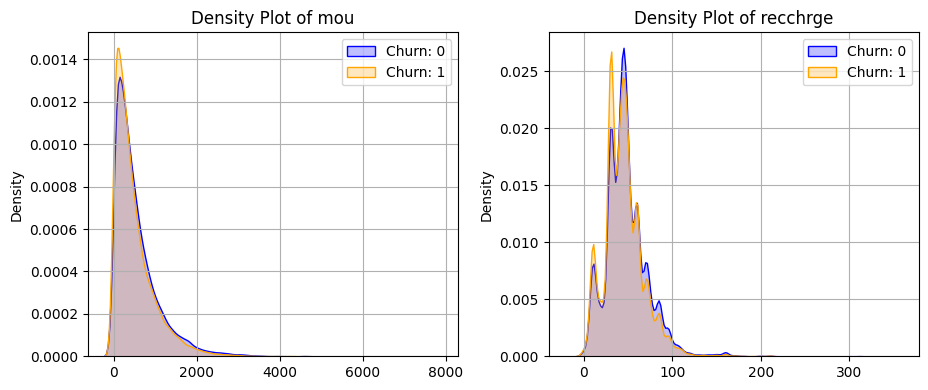

In [581]:
plot_eda_density(numerical_cols[1:3],num_cols=3)

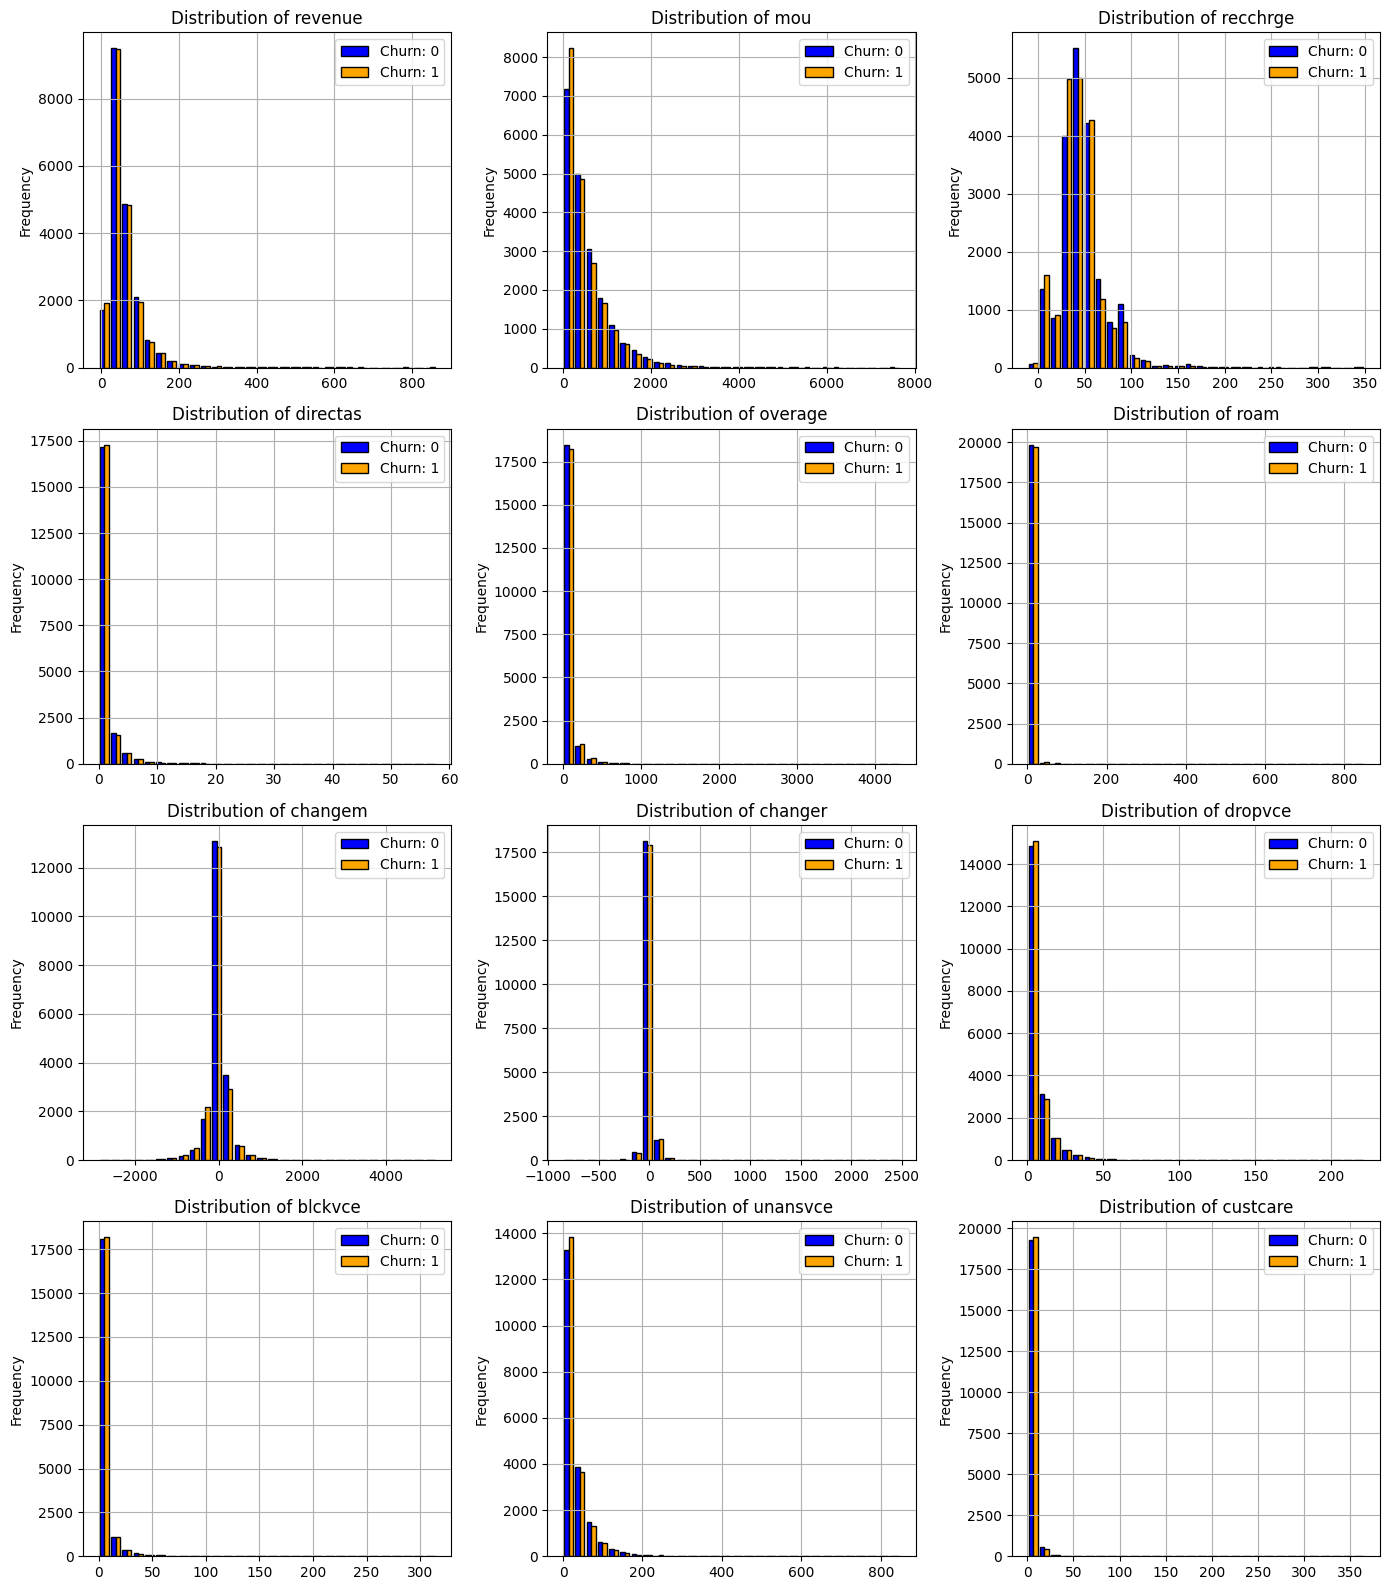

In [582]:
plot_eda(numerical_cols[0:12],num_cols=3)

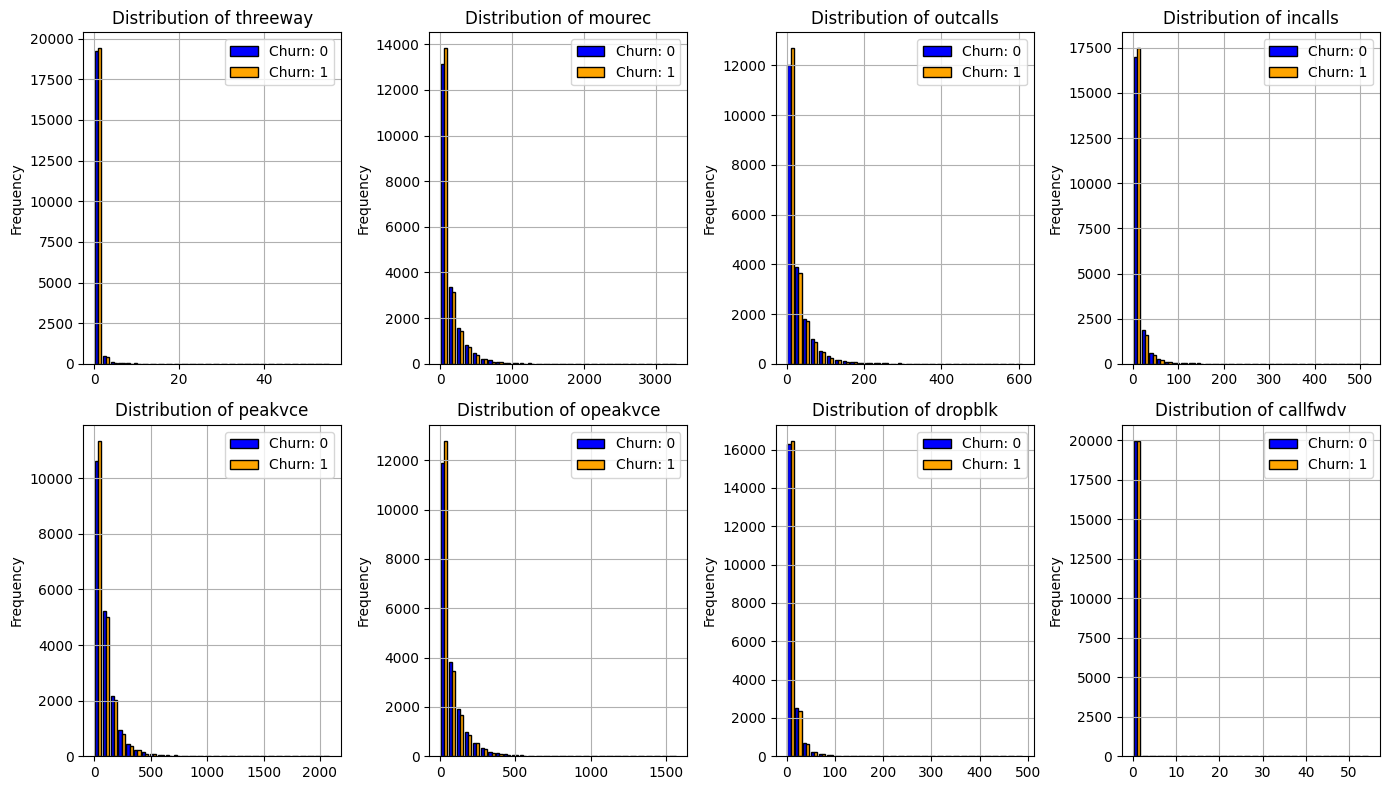

In [583]:
plot_eda(numerical_cols[12:20],num_cols=4)

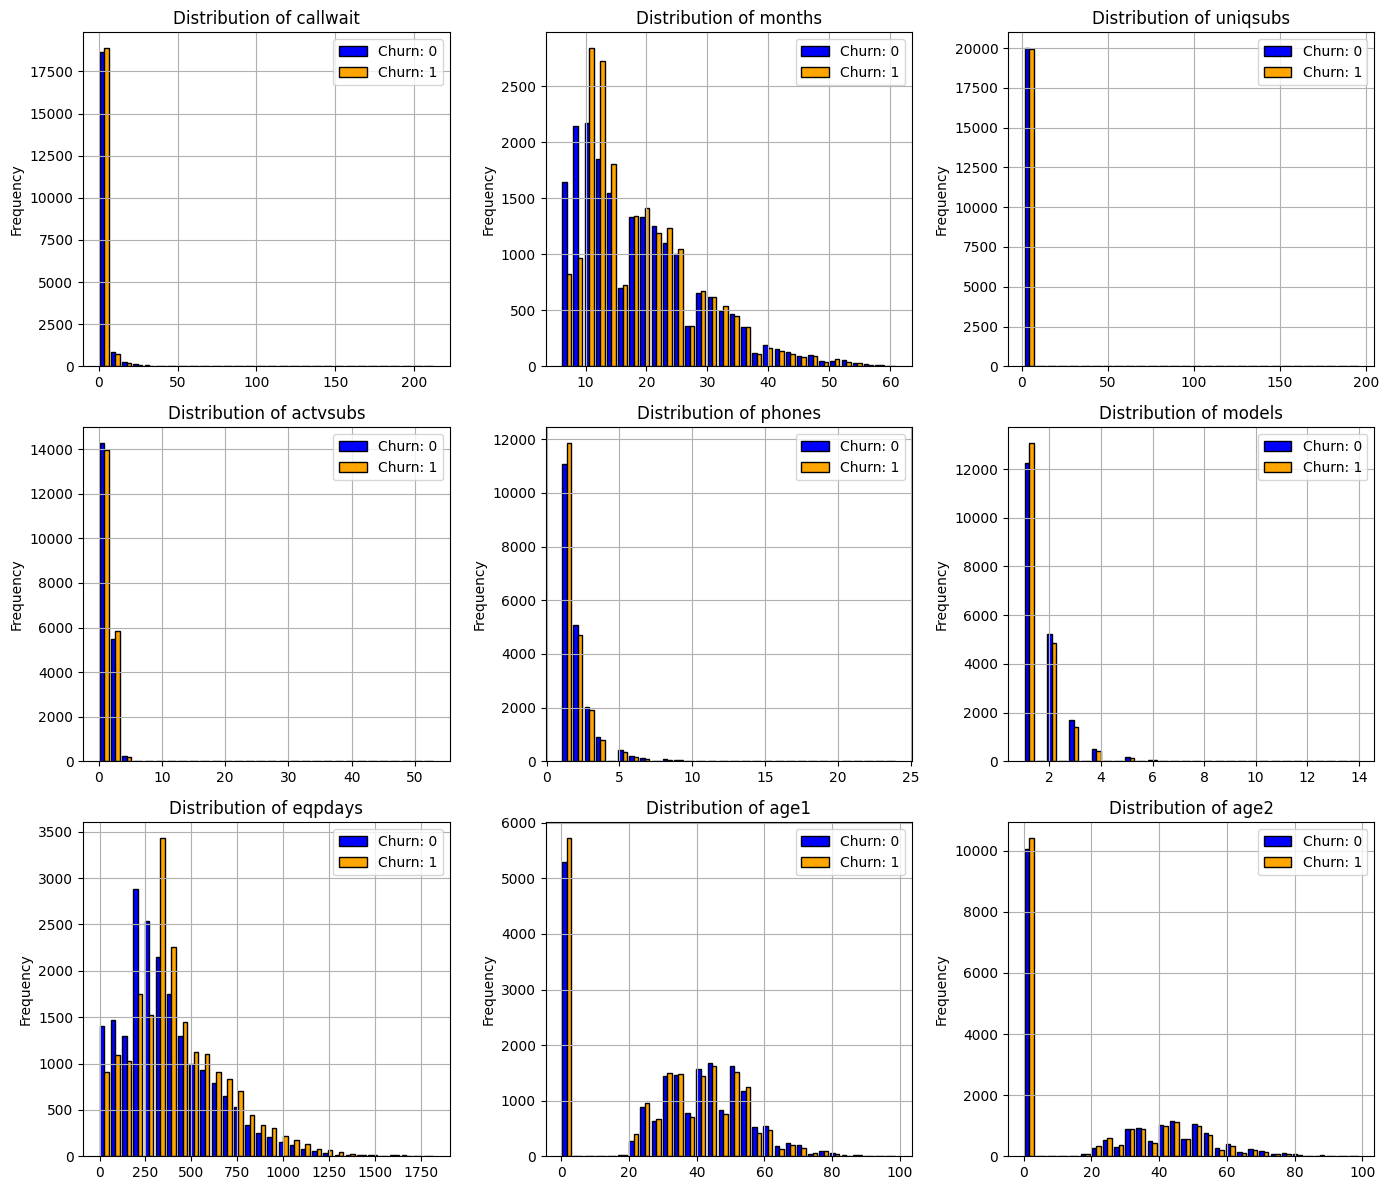

In [584]:
plot_eda(numerical_cols[20:29],num_cols=3)

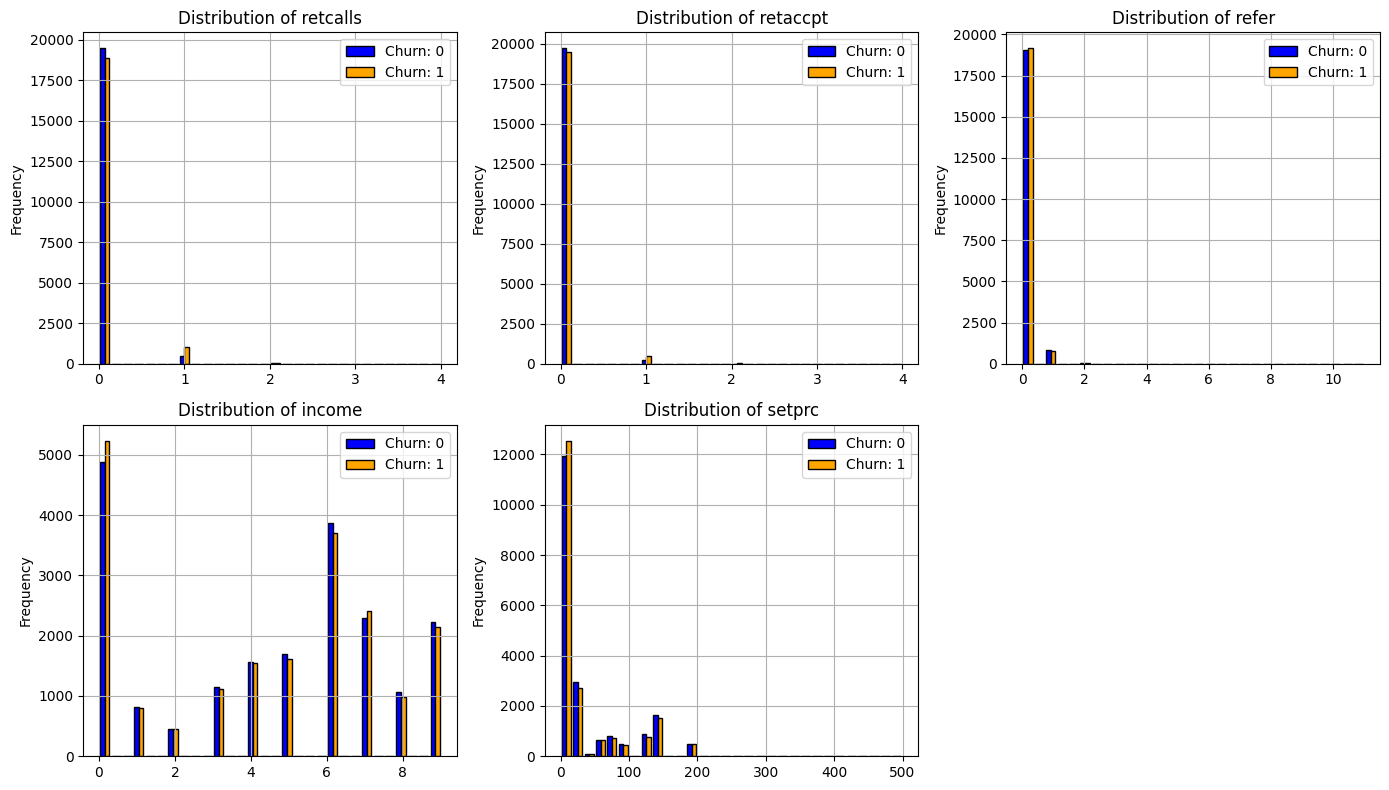

In [585]:
plot_eda(numerical_cols[29:],num_cols=3)

In [586]:
df_exp[df_exp.age1!=0]

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,refurb,webcap,truck,rv,ownrent,travel,pcown,creditcd,retcalls,retaccpt,refer,incmiss,income,mcycle,setprcm,setprc,retcall,occupation,location,credit,mailstatus,martial,cell_user_type
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000004,0,38.000000,7.50,38.000000,0.0000,0.0,0.00,-1.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.413333,0.333333,0.000000,1.333333,3.666667,0.000000,0.0,0.000000,60,1,1,1.0,1.0,1812.0,26.0,26.0,1,0,0,0,0,1,0,0,1,0,0,0,0,6,0,1,0.000000,0,crafts,town,other,other,married,new cell phone
1000005,0,55.230000,570.50,71.980003,0.0000,0.0,0.00,38.50,0.000000,9.666667,0.666667,77.000000,8.666667,0.000000,106.330002,14.666667,0.666667,97.333336,90.333336,10.333333,0.0,0.000000,57,1,1,6.0,4.0,434.0,56.0,0.0,0,0,1,0,0,0,0,1,1,0,0,0,0,6,0,0,79.989990,0,professional,other,other,other,other,new cell phone
1000008,0,38.052502,682.50,52.490002,0.2475,0.0,0.00,147.50,-3.062500,9.000000,1.666667,13.000000,0.666667,0.000000,42.196667,6.666667,0.000000,33.333332,53.000000,10.666667,0.0,0.666667,53,1,1,3.0,2.0,231.0,28.0,0.0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,29.989990,0,other,other,other,other,married,new cell phone
1000009,0,97.337502,1039.00,50.000000,4.9500,419.5,0.00,198.00,23.262501,12.666667,3.000000,176.000000,11.333333,0.333333,213.853332,103.333336,0.333333,238.333328,192.333328,15.666667,0.0,4.000000,55,1,1,3.0,3.0,700.0,38.0,24.0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,9.989998,0,crafts,suburban,other,other,married,new cell phone
1000012,0,35.294998,24.25,34.980000,0.0000,0.0,0.00,19.75,-0.315000,0.000000,0.000000,1.000000,0.000000,0.000000,2.386667,4.000000,1.666667,9.333333,1.666667,0.000000,0.0,0.000000,53,3,3,4.0,3.0,544.0,36.0,34.0,1,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,79.989990,0,other,other,other,other,married,new cell phone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099985,1,85.150002,815.00,87.989998,0.0000,1.0,0.39,0.00,0.000000,12.000000,0.000000,15.333333,0.000000,1.333333,140.973328,9.000000,3.333333,72.000000,38.666668,12.000000,0.0,0.000000,27,3,2,3.0,3.0,230.0,64.0,64.0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,39.989990,0,other,other,other,other,unknown,other
1099987,1,117.489998,384.00,29.990000,0.0000,250.0,0.00,0.00,0.000000,4.000000,1.000000,27.000000,0.000000,0.000000,21.703333,1.333333,0.000000,99.333336,54.333332,5.000000,0.0,0.000000,30,1,1,2.0,2.0,489.0,22.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,29.989990,0,professional,other,aa - rating,other,married,other
1099988,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.666667,0.000000,0.0,0.000000,25,1,1,1.0,1.0,773.0,34.0,26.0,0,0,1,0,0,0,0,1,1,0,0,0,0,6,0,1,0.000000,0,other,suburban,other,other,married,other


In [587]:
df_exp['household_avg_age']=(df_exp[df_exp.age1!=0].age1+df_exp[df_exp.age2!=0].age2)/2

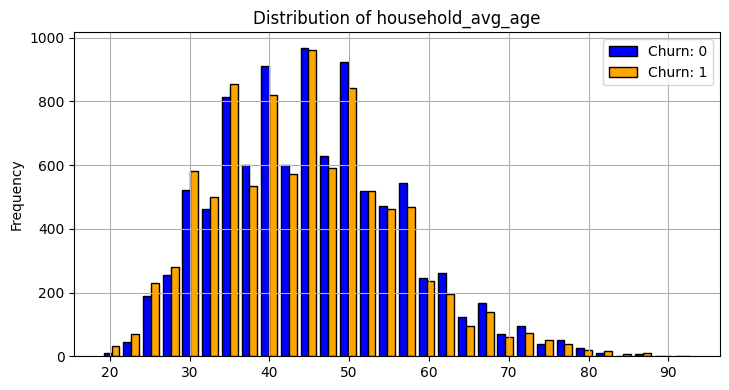

In [588]:
plot_eda(['household_avg_age'])

In [589]:
def plot_eda_binary(columns, df_fun=df_exp, num_cols=2, churn_col='churn',col_labels=True):
    # Get the unique values of the churn column
    churn_values = df_fun[churn_col].unique()
    colors = ['blue', 'orange']  # Colors for different churn categories

    # Set up the figure and axes for multiple plots
    num_plots = len(columns)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(columns):
        ax = axes[i]

        # Calculate the frequencies for each churn category
        bar_positions = np.arange(len(df_fun[col].unique()))  # Positions for the bars
        bar_width = 0.35  # Width of each bar

        for j, churn_val in enumerate(churn_values):
            data_subset = df_fun[df_fun[churn_col] == churn_val][col].value_counts().sort_index()
            ax.bar(bar_positions + j * bar_width, data_subset, width=bar_width, color=colors[j], label=f'Churn: {churn_val}',edgecolor='black')

        ax.set_title(f'{col}')
        ax.set_ylabel('Frequency')
        ax.set_xticks(bar_positions + bar_width / 2)
        ax.set_xticklabels(data_subset.index, rotation=45)  # Rotate labels for readability
        ax.grid(True)
        ax.legend()  # Add legend to differentiate churn categories
        if col_labels is True:
            ax.set_xlabel(col)
        else: 
            ax.set_xlabel('')

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [590]:
binary_cols = [col for col in df_exp.select_dtypes(include=['number']).columns if df_exp[col].nunique() == 2 and col != 'churn']

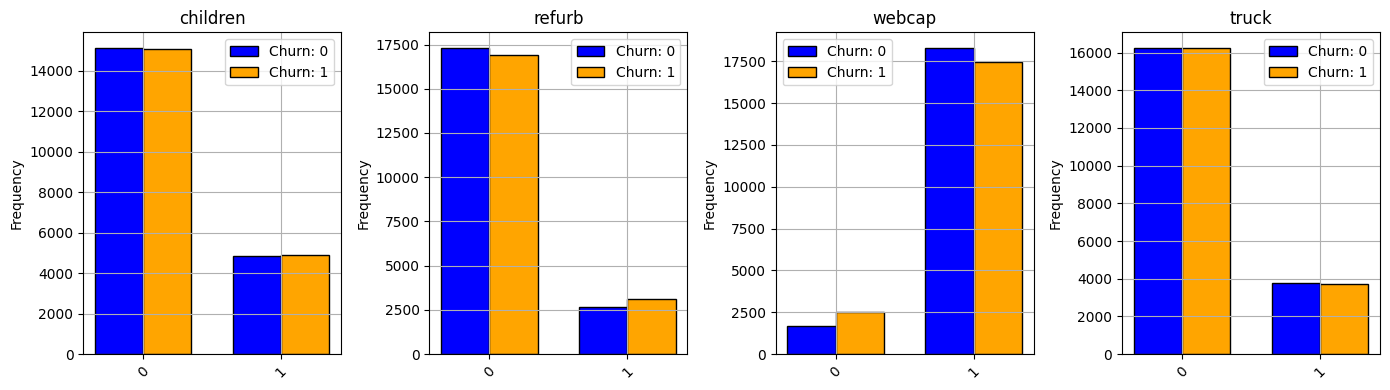

In [591]:
plot_eda_binary(binary_cols[0:4],num_cols=4,col_labels=False)

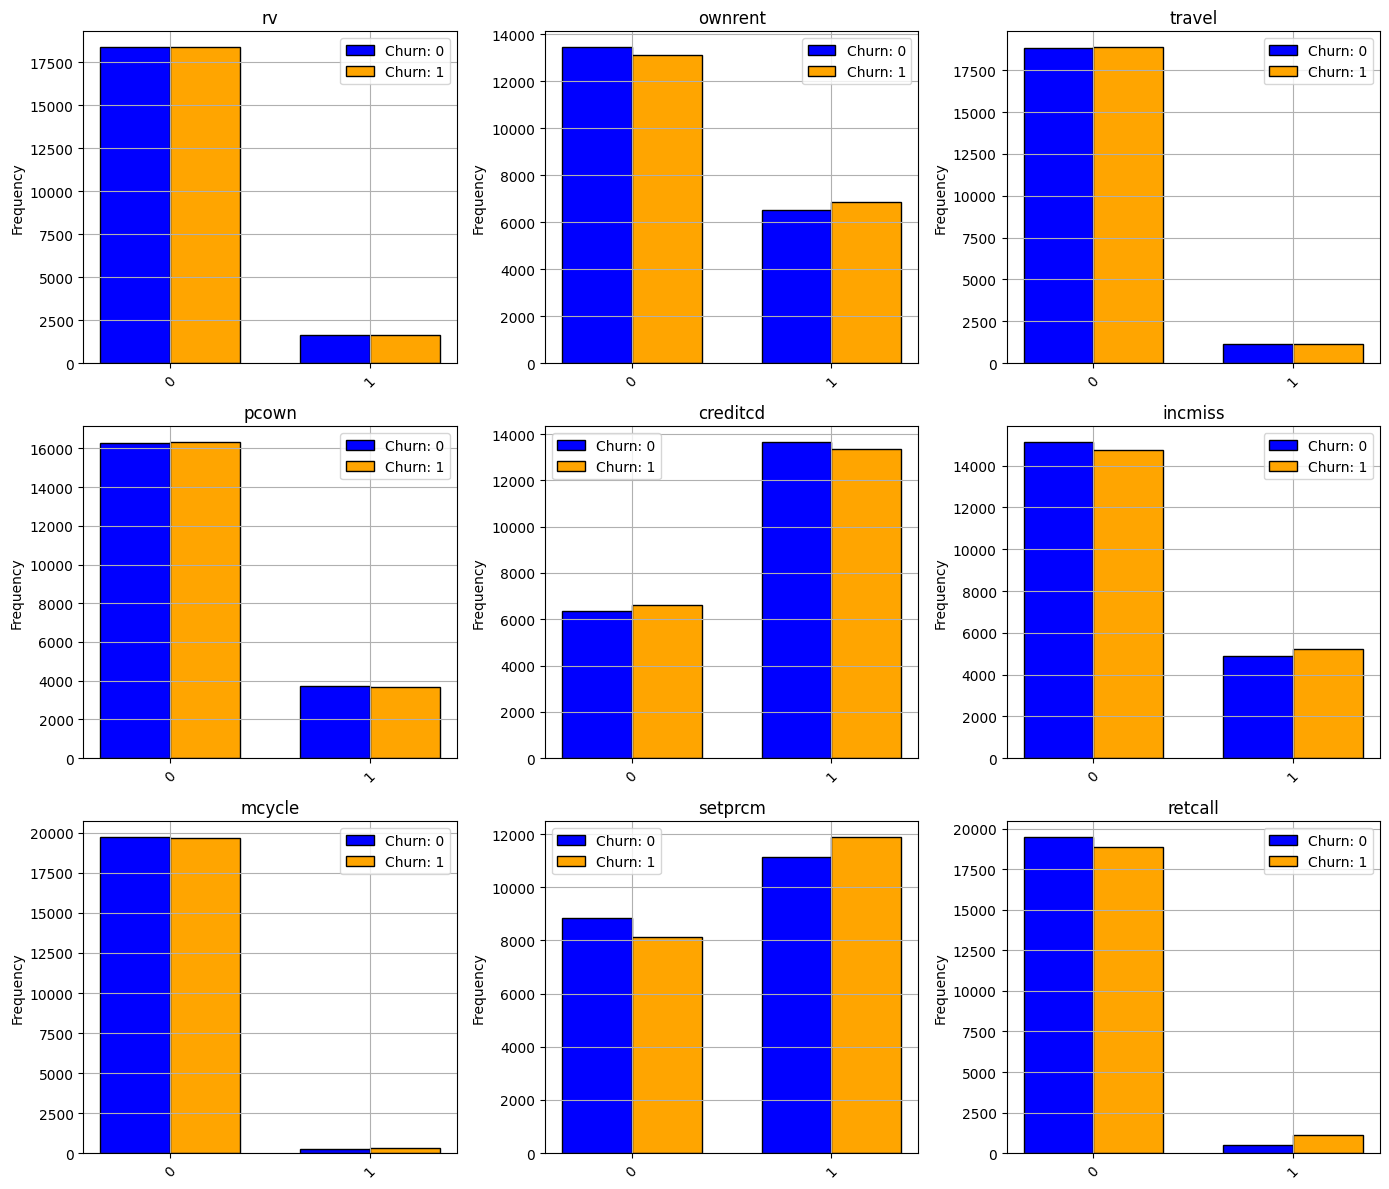

In [592]:
plot_eda_binary(binary_cols[4:],num_cols=3,col_labels=False)

In [593]:
df_exp['churn'][(df_exp.refurb==1)&(df_exp.webcap==0)].value_counts()

churn
1    495
0    297
Name: count, dtype: int64

In [594]:
df_exp['churn'][(df_exp.retcall==1)].value_counts()

churn
1    1102
0     515
Name: count, dtype: int64

In [595]:
1102/(1102+515)

0.6815089672232529

In [596]:
df_exp.shape

(40000, 55)

In [597]:
cat_cols = ['occupation','location','credit','mailstatus','martial','cell_user_type']

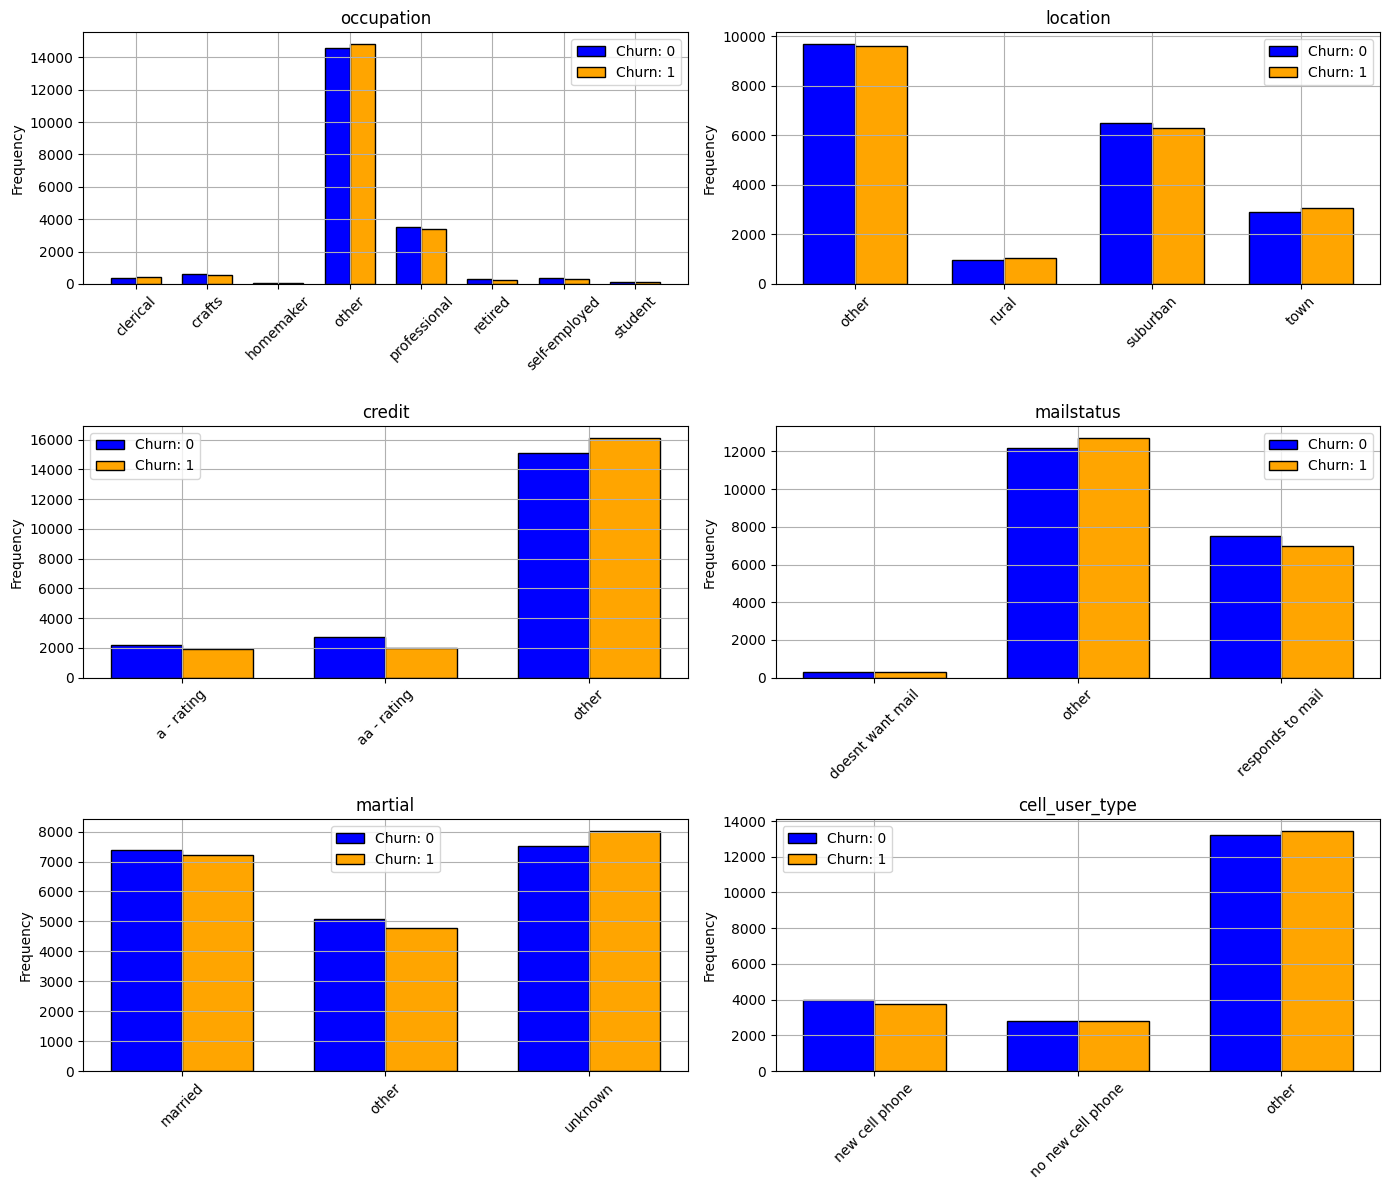

In [598]:
plot_eda_binary(cat_cols,num_cols=2,col_labels=False)

In [599]:
pd.DataFrame(df_exp[df_exp.columns[df_exp.isna().sum() > 0]].isna().sum()).T

,revenue,mou,recchrge,directas,overage,roam,changem,changer,age1,age2,household_avg_age
0,141,141,141,141,141,141,361,361,706,706,21175


In [600]:
df_exp

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,refurb,webcap,truck,rv,ownrent,travel,pcown,creditcd,retcalls,retaccpt,refer,incmiss,income,mcycle,setprcm,setprc,retcall,occupation,location,credit,mailstatus,martial,cell_user_type,household_avg_age
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000004,0,38.000000,7.50,38.000000,0.0000,0.0,0.0,-1.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.413333,0.333333,0.000000,1.333333,3.666667,0.000000,0.0,0.000000,60,1,1,1.0,1.0,1812.0,26.0,26.0,1,0,0,0,0,1,0,0,1,0,0,0,0,6,0,1,0.000000,0,crafts,town,other,other,married,new cell phone,26.0
1000005,0,55.230000,570.50,71.980003,0.0000,0.0,0.0,38.50,0.000000,9.666667,0.666667,77.000000,8.666667,0.000000,106.330002,14.666667,0.666667,97.333336,90.333336,10.333333,0.0,0.000000,57,1,1,6.0,4.0,434.0,56.0,0.0,0,0,1,0,0,0,0,1,1,0,0,0,0,6,0,0,79.989990,0,professional,other,other,other,other,new cell phone,NaN
1000008,0,38.052502,682.50,52.490002,0.2475,0.0,0.0,147.50,-3.062500,9.000000,1.666667,13.000000,0.666667,0.000000,42.196667,6.666667,0.000000,33.333332,53.000000,10.666667,0.0,0.666667,53,1,1,3.0,2.0,231.0,28.0,0.0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,29.989990,0,other,other,other,other,married,new cell phone,NaN
1000009,0,97.337502,1039.00,50.000000,4.9500,419.5,0.0,198.00,23.262501,12.666667,3.000000,176.000000,11.333333,0.333333,213.853332,103.333336,0.333333,238.333328,192.333328,15.666667,0.0,4.000000,55,1,1,3.0,3.0,700.0,38.0,24.0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,0,0,9.989998,0,crafts,suburban,other,other,married,new cell phone,31.0
1000012,0,35.294998,24.25,34.980000,0.0000,0.0,0.0,19.75,-0.315000,0.000000,0.000000,1.000000,0.000000,0.000000,2.386667,4.000000,1.666667,9.333333,1.666667,0.000000,0.0,0.000000,53,3,3,4.0,3.0,544.0,36.0,34.0,1,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,79.989990,0,other,other,other,other,married,new cell phone,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099987,1,117.489998,384.00,29.990000,0.0000,250.0,0.0,0.00,0.000000,4.000000,1.000000,27.000000,0.000000,0.000000,21.703333,1.333333,0.000000,99.333336,54.333332,5.000000,0.0,0.000000,30,1,1,2.0,2.0,489.0,22.0,0.0,0,0,1,0,0,0,0,0,1,0,0,0,0,2,0,0,29.989990,0,professional,other,aa - rating,other,married,other,NaN
1099988,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.666667,0.000000,0.0,0.000000,25,1,1,1.0,1.0,773.0,34.0,26.0,0,0,1,0,0,0,0,1,1,0,0,0,0,6,0,1,0.000000,0,other,suburban,other,other,married,other,30.0
1099990,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.333333,2.666667,48.333332,0.000000,0.000000,58.923332,17.000000,1.333333,160.333328,33.333332,12.000000,0.0,0.333333,29,1,1,2.0,2.0,526.0,68.0,64.0,0,1,1,0,0,0,0,0,1,0,0,0,0,6,0,0,59.989990,0,other,suburban,other,responds to mail,married,other,66.0


In [601]:
df_exp.drop(columns='household_avg_age').isna().any(axis=1).sum()

1059

In [602]:
df_exp['income'].value_counts()

income
0    10106
6     7564
7     4699
9     4370
5     3318
4     3120
3     2270
8     2042
1     1609
2      902
Name: count, dtype: int64

In [603]:
df_exp['setprc'].value_counts()

setprc
0.000000      23037
29.989990      5633
149.989990     3157
129.989990     1641
79.989990      1521
9.989998       1458
59.989990      1332
199.989990      977
99.989990       960
39.989990       197
399.989990       30
249.989990       26
299.989990       11
179.989990        9
499.989990        7
239.989990        4
Name: count, dtype: int64

In [604]:
11022/40000

0.27555

In [605]:
df_exp.age1.value_counts()

age1
0.0     11022
46.0     1679
44.0     1626
50.0     1623
48.0     1595
42.0     1561
36.0     1530
52.0     1520
38.0     1493
30.0     1473
32.0     1466
40.0     1459
34.0     1413
54.0     1359
28.0     1313
26.0     1153
56.0     1060
58.0      931
24.0      688
60.0      630
22.0      453
62.0      381
64.0      322
66.0      229
20.0      223
68.0      208
70.0      189
72.0      172
76.0      106
74.0      102
78.0       78
80.0       63
18.0       42
82.0       37
84.0       29
86.0       21
88.0       20
90.0       11
92.0        5
94.0        4
98.0        2
96.0        2
99.0        1
Name: count, dtype: int64

In [606]:
20469/40000

0.511725

In [607]:
df_exp.age2.value_counts()

age2
0.0     20469
44.0     1145
46.0     1135
48.0     1130
42.0     1065
50.0     1063
52.0      977
40.0      969
36.0      946
38.0      932
32.0      891
34.0      876
30.0      874
54.0      842
28.0      689
56.0      599
26.0      586
24.0      538
58.0      476
60.0      402
22.0      343
62.0      331
20.0      291
64.0      271
66.0      232
68.0      211
70.0      166
18.0      153
74.0      132
72.0      130
78.0       98
76.0       89
80.0       74
82.0       40
84.0       35
86.0       27
90.0       22
88.0       19
94.0        7
92.0        7
98.0        7
96.0        3
99.0        2
Name: count, dtype: int64

# Data Transformation

In [608]:
df

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
customer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000004,0,38.000000,7.50,38.000000,0.0000,0.0,0.0,-1.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.413333,0.333333,0.000000,1.333333,3.666667,0.000000,0.0,0.000000,60,1,1,1.0,1.0,1812.0,26.0,26.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,6,0,1,0.000000,0
1000005,0,55.230000,570.50,71.980003,0.0000,0.0,0.0,38.50,0.000000,9.666667,0.666667,77.000000,8.666667,0.000000,106.330002,14.666667,0.666667,97.333336,90.333336,10.333333,0.0,0.000000,57,1,1,6.0,4.0,434.0,56.0,0.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,6,0,0,79.989990,0
1000008,0,38.052502,682.50,52.490002,0.2475,0.0,0.0,147.50,-3.062500,9.000000,1.666667,13.000000,0.666667,0.000000,42.196667,6.666667,0.000000,33.333332,53.000000,10.666667,0.0,0.666667,53,1,1,3.0,2.0,231.0,28.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,29.989990,0
1000009,0,97.337502,1039.00,50.000000,4.9500,419.5,0.0,198.00,23.262501,12.666667,3.000000,176.000000,11.333333,0.333333,213.853332,103.333336,0.333333,238.333328,192.333328,15.666667,0.0,4.000000,55,1,1,3.0,3.0,700.0,38.0,24.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,9.989998,0
1000012,0,35.294998,24.25,34.980000,0.0000,0.0,0.0,19.75,-0.315000,0.000000,0.000000,1.000000,0.000000,0.000000,2.386667,4.000000,1.666667,9.333333,1.666667,0.000000,0.0,0.000000,53,3,3,4.0,3.0,544.0,36.0,34.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,9,0,0,79.989990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099987,1,117.489998,384.00,29.990000,0.0000,250.0,0.0,0.00,0.000000,4.000000,1.000000,27.000000,0.000000,0.000000,21.703333,1.333333,0.000000,99.333336,54.333332,5.000000,0.0,0.000000,30,1,1,2.0,2.0,489.0,22.0,0.0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,29.989990,0
1099988,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.666667,0.000000,0.0,0.000000,25,1,1,1.0,1.0,773.0,34.0,26.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,6,0,1,0.000000,0
1099990,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.333333,2.666667,48.333332,0.000000,0.000000,58.923332,17.000000,1.333333,160.333328,33.333332,12.000000,0.0,0.333333,29,1,1,2.0,2.0,526.0,68.0,64.0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,6,0,0,59.989990,0


In [609]:
df[df.columns[df.isna().sum() > 0]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 40000 entries, 1000004 to 1099995
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   revenue   39859 non-null  float64
 1   mou       39859 non-null  float64
 2   recchrge  39859 non-null  float64
 3   directas  39859 non-null  float64
 4   overage   39859 non-null  float64
 5   roam      39859 non-null  float64
 6   changem   39639 non-null  float64
 7   changer   39639 non-null  float64
 8   age1      39294 non-null  float64
 9   age2      39294 non-null  float64
dtypes: float64(10)
memory usage: 3.4 MB


In [610]:
df[df.columns[df.isna().sum() > 0]].isna().sum()

revenue     141
mou         141
recchrge    141
directas    141
overage     141
roam        141
changem     361
changer     361
age1        706
age2        706
dtype: int64

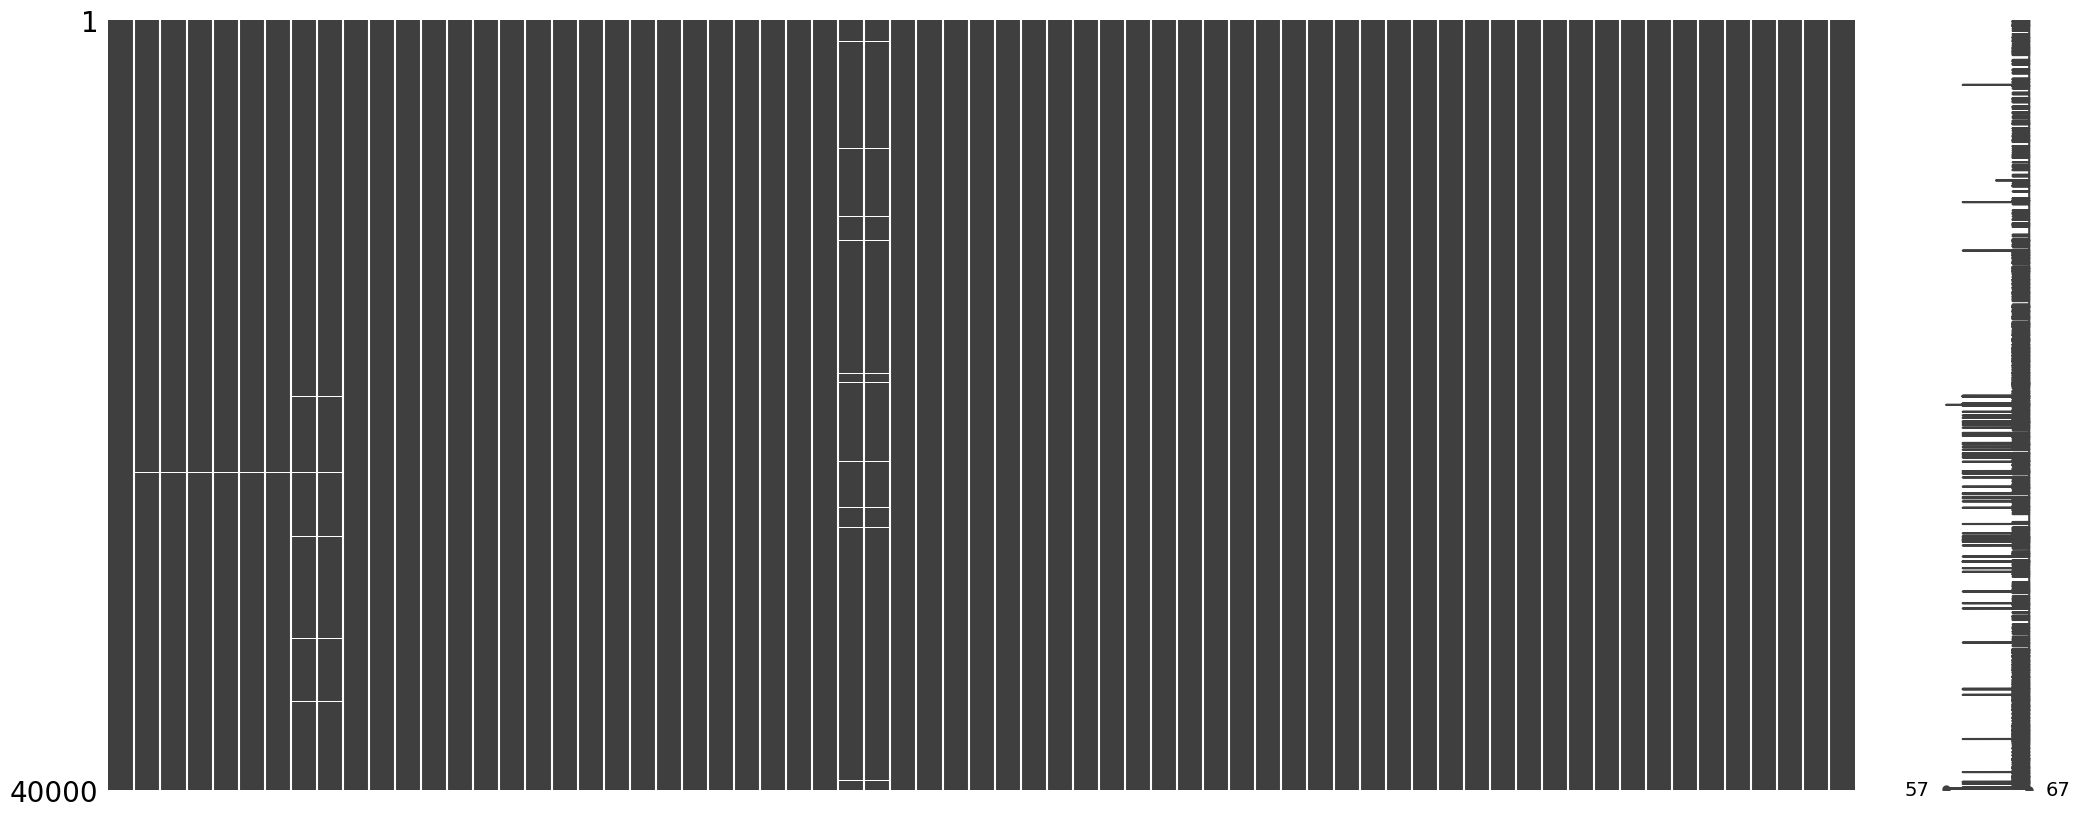

In [611]:
msno.matrix(df)
plt.show()

Text(0.5, 1.0, 'Heatmapa braków danych')

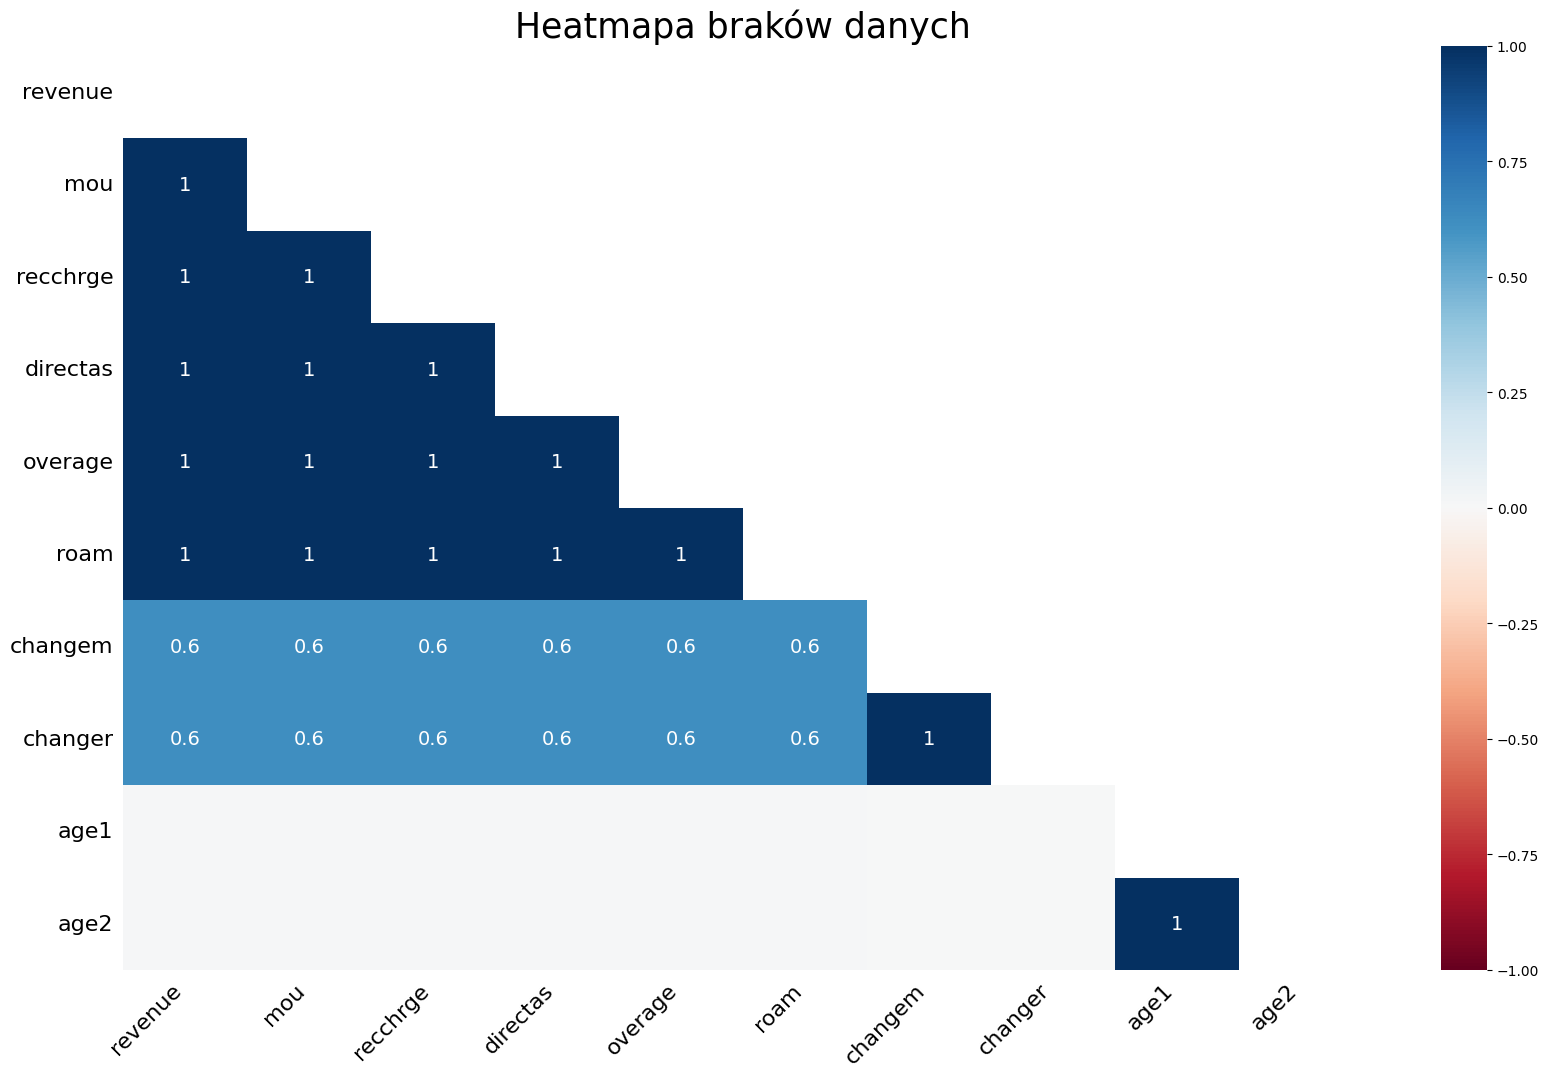

In [612]:
msno.heatmap(df)
plt.title('Heatmapa braków danych',fontsize=25)

In [613]:
numerical_cols

['revenue',
 'mou',
 'recchrge',
 'directas',
 'overage',
 'roam',
 'changem',
 'changer',
 'dropvce',
 'blckvce',
 'unansvce',
 'custcare',
 'threeway',
 'mourec',
 'outcalls',
 'incalls',
 'peakvce',
 'opeakvce',
 'dropblk',
 'callfwdv',
 'callwait',
 'months',
 'uniqsubs',
 'actvsubs',
 'phones',
 'models',
 'eqpdays',
 'age1',
 'age2',
 'retcalls',
 'retaccpt',
 'refer',
 'income',
 'setprc']

use knn imputer to imput missing values for the rest of columns
- roam - mean number of roaming calls
- revenue - mean monthly reve
- mou - mean monthly minutes of use
- reccharge - mean total recuring charge
- directas - Mean number of director assisted calls
- Overage - represents calls or minutes of use over the number of minutes allowed by that customer's calling plan.
- changem/changer - % Change in minutes of use/% Change in revenues
- agehh1
- agehh2

In [614]:
def evaluate_knn_imputation(df, max_k=8):
    # 1. Get a list of columns with NA in input df
    na_columns = df.columns[df.isna().any()].tolist()
    
    # 2. Drop NA's from the df
    df_clean = df.dropna()
    
    # 3. Create a random subset size of 50% of its original observations of df_clean
    subset_size = int(len(df_clean) * 0.5)
    df_subset = df_clean.sample(n=subset_size, random_state=1973)
    
    # 4. Set 200 random indexes which will later be inputted with NA's
    random.seed(1973)
    random_indexes = random.sample(range(subset_size), 200)
    
    # 5. Scaling the variables that do not have NA's
    scaler = StandardScaler()
    non_na_columns = [col for col in df_subset.columns if col not in na_columns]
    df_subset[non_na_columns] = scaler.fit_transform(df_subset[non_na_columns])
    
    results = []

    # 6. Loop through each column in na_columns
    for col in na_columns:
        print(col)
        # Copy the subset to not affect the original
        df_test = df_subset.copy()

        # 7. Input NA's for that column at the selected random indexes
        original_values = df_test.iloc[random_indexes][col].values
        df_test.loc[df_test.index[random_indexes], col] = np.nan
        
        # 8. Apply KNN imputation
        for k in range(1, max_k + 1):
            # Apply KNN imputation
            imputer = KNNImputer(n_neighbors=k)
            df_imputed = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)
            
            # 9. Calculate MSE for the imputed column at the selected random indexes
            imputed_values = df_imputed.iloc[random_indexes][col].values
            mse = mean_squared_error(original_values, imputed_values)
            
            # 10. Store the results in the list
            results.append({'k': k, 'column': col, 'mse': mse})

    # 11. Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [615]:
df_elbow=evaluate_knn_imputation(df,max_k=8)

revenue
mou
recchrge
directas
overage
roam
changem
changer
age1
age2


In [616]:
df_elbow=df_elbow.pivot(index='k',columns='column',values='mse').reset_index()

In [617]:
df_elbow

column,k,age1,age2,changem,changer,directas,mou,overage,recchrge,revenue,roam
0,1,697.880000,785.300000,68234.723993,856.340205,7.610783,136498.760625,2083.568715,202.053765,360.104705,12.183913
1,2,469.825000,653.665000,49635.384748,576.897992,6.474445,101006.772639,1458.942439,164.864461,242.331695,13.441336
2,3,395.626667,618.246667,50834.159460,508.633601,4.892680,89615.368265,1414.565181,156.140741,229.113576,12.621087
3,4,358.855000,556.658750,45107.208830,467.924129,5.340669,85488.519564,1429.713876,156.254722,223.056051,11.523386
4,5,345.752000,563.586400,45137.660785,459.036902,4.686081,84568.372054,1450.455925,157.496953,197.887365,12.015424
5,6,336.846667,504.175000,45774.296837,431.400277,4.506934,79741.257923,1370.758262,155.467328,204.554547,11.295926
6,7,329.989388,479.616735,44981.220575,437.232346,4.176500,80591.274150,1309.846280,152.221206,202.806380,11.544549
7,8,320.385000,479.553125,45090.241026,417.839388,4.244508,79994.877373,1226.296236,152.185027,199.560961,11.028018


In [618]:
def plot_elbow_method_results(wcss_df):
    # Number of columns to plot (excluding the 'k' column)
    columns_to_plot = wcss_df.columns.drop('k')
    num_columns = len(columns_to_plot)

    # Create a 2x5 grid (adjust based on the number of columns to plot)
    row_count=wcss_df.shape[1]-1
    fig, axes = plt.subplots(nrows=row_count, ncols=2, figsize=(10, 30))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        if i >= len(axes):  # Just in case there are more columns than grid slots
            break
        
        # Plot WCSS for the current column
        axes[i].plot(wcss_df['k'], wcss_df[column], marker='o')
        axes[i].set_title(f'Metoda łokciowa dla {column}')
        axes[i].set_xlabel('Liczba sąsiadów (k)')
        axes[i].set_ylabel('błąd średniokwadroatowy')
    
    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


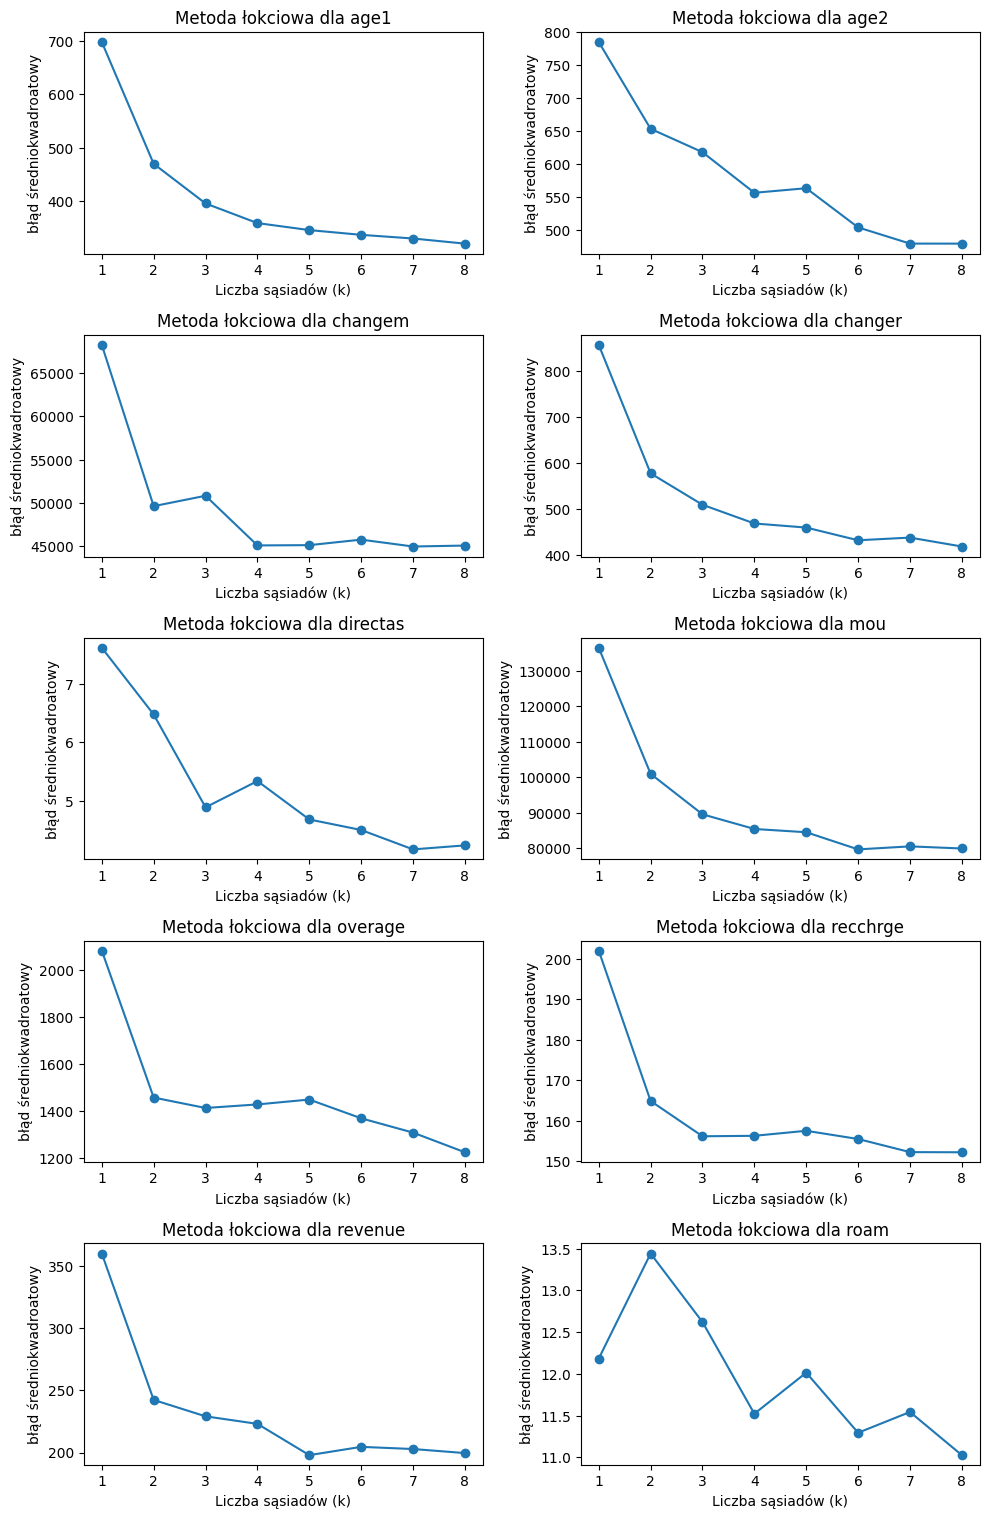

In [619]:
plot_elbow_method_results(df_elbow)

In [620]:
col_inputs = {
    'revenue': 5,
    'mou': 6,
    'recchrge': 3,
    'directas': 3,
    'overage': 3,
    'roam': 4,
    'changem': 4,
    'changer': 6,
    'age1': 4,
    'age2': 4}


In [621]:
# def knn_impute_by_column(df, col_inputs):
#     df_imputed = df.copy()  # Tworzymy kopię DataFrame, aby nie modyfikować oryginału
    
#     for col, k in col_inputs.items():
#         if col in df.columns:  # Sprawdzamy, czy kolumna istnieje w DataFrame
#             # Tworzymy obiekt KNNImputer z podanym k
#             imputer = KNNImputer(n_neighbors=k)
            
#             # Uzupełniamy brakujące wartości dla danej kolumny
#             df_imputed[[col]] = imputer.fit_transform(df_imputed[[col]])
    
#     return df_imputed

In [622]:
def knn_impute_by_column(df, col_inputs):
    df_imputed = df.copy()  # Tworzymy kopię DataFrame, aby nie modyfikować oryginału
    
    for col, k in col_inputs.items():
        if col in df.columns:  # Sprawdzamy, czy kolumna istnieje w DataFrame
            # Tworzymy obiekt KNNImputer z podanym k
            imputer = KNNImputer(n_neighbors=k)
            scaler = StandardScaler()

            # Scale the column before imputing
            scaled_col = scaler.fit_transform(df_imputed[[col]])
            
            # Perform KNN imputation on the scaled data
            imputed_scaled_col = imputer.fit_transform(scaled_col)
            
            # Inverse transform the scaled imputed values back to the original scale
            imputed_col = scaler.inverse_transform(imputed_scaled_col)
            
            # Replace the original column with the imputed values (keeping other rows intact)
            df_imputed.loc[df_imputed[col].isna(), col] = imputed_col[df_imputed[col].isna()]
    
    return df_imputed
    # return df_imputed

In [623]:
df=knn_impute_by_column(df,col_inputs)

In [624]:
df.describe()

,churn,revenue,mou,recchrge,directas,overage,roam,changem,changer,dropvce,blckvce,unansvce,custcare,threeway,mourec,outcalls,incalls,peakvce,opeakvce,dropblk,callfwdv,callwait,months,uniqsubs,actvsubs,phones,models,eqpdays,age1,age2,children,credita,creditaa,prizmrur,prizmub,prizmtwn,refurb,webcap,truck,rv,occprof,occcler,occcrft,occstud,occhmkr,occret,occself,ownrent,marryun,marryyes,mailord,mailres,mailflag,travel,pcown,creditcd,retcalls,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,0.500000,58.632643,513.973510,46.271960,0.878711,40.863133,1.228694,-15.006928,-0.939337,5.940213,4.030525,27.771762,1.778229,0.284450,112.157275,24.836208,7.993717,88.685446,66.074488,10.046646,0.009167,1.790696,18.831750,1.551675,1.35925,1.788325,1.543400,392.839500,31.062427,21.016746,0.244325,0.101700,0.11815,0.049800,0.318825,0.149300,0.144725,0.894900,0.187400,0.081625,0.173550,0.020025,0.029150,0.007300,0.003025,0.014225,0.017850,0.335125,0.388350,0.365325,0.357225,0.372425,0.015075,0.057075,0.185325,0.675825,0.044025,0.020425,0.193100,0.140600,0.047850,0.252650,4.330900,0.013950,0.575925,34.976005,0.040425
std,0.500006,44.064561,523.834161,23.672311,2.068899,98.098749,8.315157,258.472167,39.580949,8.880774,10.495103,38.250252,5.175107,1.074865,165.082658,34.764911,16.611850,102.933661,91.916943,15.348324,0.472957,5.375079,9.624604,1.314600,0.68480,1.319891,0.893553,256.715982,21.862023,23.599567,0.429692,0.302257,0.32279,0.217534,0.466027,0.356388,0.351828,0.306686,0.390237,0.273796,0.378727,0.140087,0.168229,0.085129,0.054917,0.118419,0.132408,0.472040,0.487381,0.481527,0.479188,0.483457,0.121853,0.231989,0.388566,0.468072,0.224584,0.150693,0.394736,0.347613,0.249223,0.434537,3.144329,0.117285,0.494208,56.620460,0.196956
min,0.000000,-5.862500,0.000000,-11.290000,0.000000,0.000000,0.000000,-2867.500000,-851.104981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,0.00000,1.000000,1.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.437500,152.000000,30.000000,0.000000,0.000000,0.000000,-86.250000,-6.992500,0.666667,0.000000,5.000000,0.000000,0.000000,7.606667,3.000000,0.000000,21.666666,10.333333,1.666667,0.000000,0.000000,11.000000,1.000000,1.00000,1.000000,1.000000,212.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,48.552502,358.500000,44.990002,0.247500,3.000000,0.000000,-7.000000,-0.315000,3.000000,1.000000,16.000

In [625]:
df[df.columns[df.isna().sum() > 0]].isna().sum()

Series([], dtype: float64)

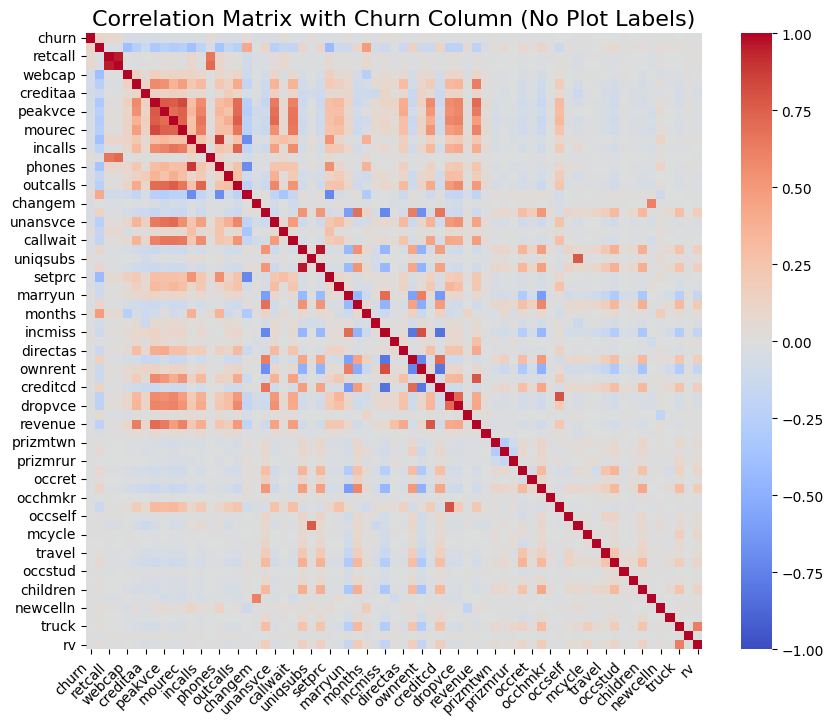

In [626]:
corr_matrix = df.corr()

# Extract the correlations involving the churn column and other variables that correlate with churn
columns_of_interest = corr_matrix['churn'].abs().sort_values(ascending=False).index
selected_corr_matrix = corr_matrix.loc[columns_of_interest, columns_of_interest]

# Plot the correlation matrix with variable labels but no axis labels
plt.figure(figsize=(10, 8))
sns.heatmap(selected_corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True, square=True)

# Remove axis labels but keep the variable labels
plt.title('Correlation Matrix with Churn Column (No Plot Labels)', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Adjust tick labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.show()

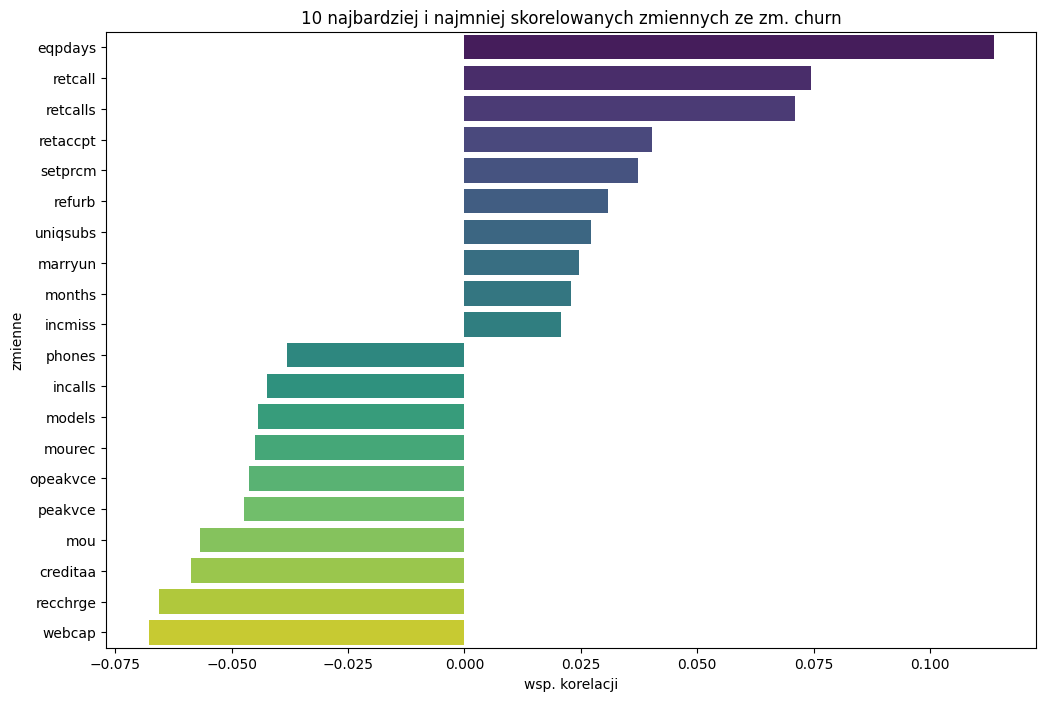

In [627]:
correlation_matrix = df.corr()
churn_correlation = correlation_matrix['churn'].sort_values()
most_correlated = churn_correlation.tail(11).head(10)  # Exclude the 'Churn' correlation with itself
least_correlated = churn_correlation.head(10)
combined_correlations = pd.concat([most_correlated, least_correlated]).sort_values(ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x=combined_correlations.values, y=combined_correlations.index, palette='viridis')
plt.title('10 najbardziej i najmniej skorelowanych zmiennych ze zm. churn')
plt.xlabel('wsp. korelacji')
plt.ylabel('zmienne')
plt.show()

## modeling

How can we improve model? Depends what we aim for?

1. define the problem
1. Here choose a model metric we will be looking to optimise based on market reports and current tactics (google!)

1. EDA and approach to data cleaning manipulation
1. train test split target VAR description

1. Create base LR model to see how it performs
2. See how good can you make LR model by tuning hyperparameters training by using KFOLD / resampling train test and so on
    - we will have lots and lots of variables so using lasso/ ridge could turn out good explain them and see which parameter does the trick
    - adding variable combinations if possible and they make sense as a one way to improve a model
    - outline the advantages of LR such as interpretability of results coefficients and so on

3. ML Methods bagging XGB RandomForest
    - tweaking them by randomgridsearch/ gridsearch
    - train/test rebalancing by undersampling oversampling/ smooten
    - same methods as above 


#### LEVERAGE LIFT USE XD BECAUSE IT SOUNDS WELL

4. Neural network maybe? Idk about the volume of Prior work
5. Sum up the work which model performed better and so on. State that its dependent in use case and recommend using one based on this paper in this case and current trends.

In [628]:
pd.set_option('display.max_columns', None)

# Train Test Split


In [629]:
X = df.drop(columns=['churn'])
y = df['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1973)

In [630]:
holdout_df=knn_impute_by_column(holdout_df,col_inputs)

In [631]:
mean_values = df.mean()

holdout_df = holdout_df.fillna(mean_values)

In [632]:
X_hold = holdout_df.drop(columns=['churn'])
y_hold = holdout_df['churn']

## Baseline model

In [634]:
def evaluate_model(y_pred_proba, y_test, ret_df=False, plot_roc=False, name='model_name'):
    # Convert probabilities to class predictions based on a threshold of 0.5
    y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Assuming 'Yes' is the positive class
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_proba[:,1])
    
    print(f"""Model Performance: 
    Accuracy = {round(accuracy*100, 3)}%
    Recall = {round(recall*100, 3)}%
    Precision = {round(precision*100, 3)}%
    F1 Score = {round(f1*100, 3)}%
    """)
    
    if plot_roc == True:
        # Plotting the ROC curve with different thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])
        plt.figure()
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {round(auc, 3)})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - {name}')
        plt.legend(loc="lower right")
        print(f'AUC = {round(auc*100, 3)}%')

        # # Annotate the thresholds
        # for i in range(len(thresholds)):
        #     plt.annotate(f'{round(thresholds[i], 2)}', 
        #                 xy=(fpr[i], tpr[i]), 
        #                 textcoords='offset points', 
        #                 xytext=(0, 10), 
        #                 ha='center')
        
    plt.show()

    if ret_df:
        metrics = {
            'model': [name],
            'Accuracy': [accuracy],
            'Recall': [recall],
            'Precision': [precision],
            'F1 Score': [f1],
            'AUC': [auc]
        }
        return pd.DataFrame(metrics)

In [635]:
def simple_eval(y_pred, y_test, ret_df=False, name='model_name'):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # Assuming 'Yes' is the positive class
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred)
    
    print(f"""Model Performance: 
    Accuracy = {round(accuracy*100, 3)}%
    Recall = {round(recall*100, 3)}%
    Precision = {round(precision*100, 3)}%
    F1 Score = {round(f1*100, 3)}%
    AUC = {round(auc*100, 3)}%
    """)

    if ret_df:
        metrics = {
            'model': [name],
            'Accuracy': [accuracy],
            'Recall': [recall],
            'Precision': [precision],
            'F1 Score': [f1],
            'AUC': [auc]
        }
        return pd.DataFrame(metrics)

Model Performance: 
    Accuracy = 51.875%
    Recall = 51.255%
    Precision = 50.684%
    F1 Score = 50.968%
    AUC = 51.86%
    
None and 1
Model Performance: 
    Accuracy = 52.438%
    Recall = 27.51%
    Precision = 52.416%
    F1 Score = 36.083%
    AUC = 51.853%
    
None and 2


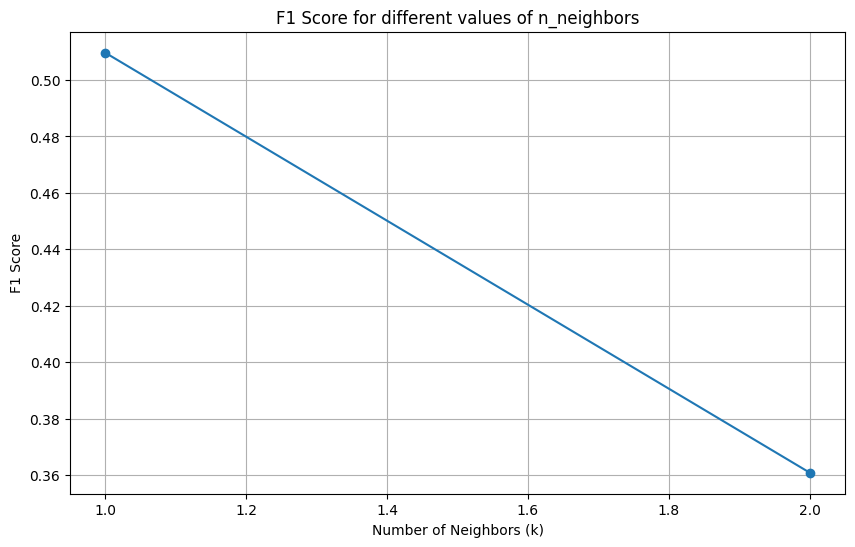

In [652]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Range of n_neighbors to test
n_neighbors_range = range(1, 3)

# List to store the F1 scores for different n_neighbors
f1_scores = []

for k in n_neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)  # Adjust 'average' as needed, e.g., average='weighted' for multiclass
    f1_scores.append(f1)
    print(f"{simple_eval(y_pred, y_test)} and {k}")

# Plotting the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_range, f1_scores, marker='o')
plt.title('F1 Score for different values of n_neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [653]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
X_hold_scaled = scaler.transform(X_hold)
y_pred = knn.predict(X_hold_scaled)
y_proba = knn.predict_proba(X_hold_scaled)

Model Performance: 
    Accuracy = 52.324%
    Recall = 52.381%
    Precision = 2.151%
    F1 Score = 4.132%
    
AUC = 52.352%


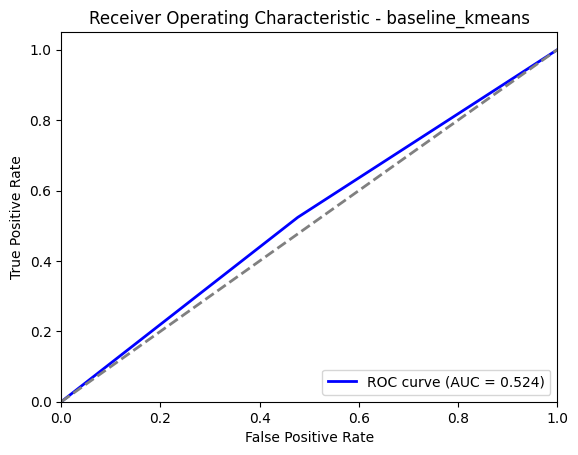

In [654]:
results=evaluate_model(y_proba,y_hold,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [ ]:
y_pred_base = pd.DataFrame()

In [ ]:
y_pred_base['y_pred'] = (
    (X_test['eqpdays'] >= 350) |
    ((X_test['months'] >= 10) & (X_test['months'] <= 15)) |
    (X_test['retcall'] == 1) |
    (X_test['webcap'] == 0) |
    (X_test['refurb'] == 1)
).astype(int)

# y_pred_base will now have a column y_pred with 1 or 0 based on the conditions
print(y_pred_base)

          y_pred
customer        
1030436        1
1029059        1
1011270        0
1027662        1
1091973        1
...          ...
1059605        1
1087419        1
1014631        1
1087653        1
1005115        1

[8000 rows x 1 columns]


In [ ]:
simple_eval(y_pred_base,y_test,ret_df=True,name='baseline_kmeans')

Model Performance: 
    Accuracy = 57.612%
    Recall = 82.941%
    Precision = 54.302%
    F1 Score = 65.633%
    AUC = 58.206%
    


,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.576125,0.829406,0.543015,0.656329,0.582061


In [ ]:
y_hold_base_pred=pd.DataFrame()

In [ ]:
y_hold_base_pred['y_pred'] = (
    (X_hold['eqpdays'] >= 350) |
    ((X_hold['months'] >= 10) & (X_hold['months'] <= 15)) |
    (X_hold['retcall'] == 1) |
    (X_hold['webcap'] == 0) |
    (X_hold['refurb'] == 1)
).astype(int)

          y_pred
customer        
1000002        0
1000006        1
1000010        1
1000011        1
1000014        1
...          ...
1099785        0
1099957        1
1099958        1
1099971        1
1099979        1

[31047 rows x 1 columns]


In [ ]:
simple_eval(y_hold_base_pred,y_hold,ret_df=True,name='baseline_kmeans')

Model Performance: 
    Accuracy = 33.159%
    Recall = 84.072%
    Precision = 2.419%
    F1 Score = 4.702%
    AUC = 58.106%
    


,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.331594,0.840722,0.024189,0.047024,0.581065


# KFOLD

In [732]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1973)

In [733]:
scoring = make_scorer(accuracy_score, average='weighted')  # Adjust 'average' depending on your problem

# XGB

In [746]:
30000/1000

30.0

In [769]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Train the model on the training data
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [770]:
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb=xgb_model.predict_proba(X_test)

Model Performance: 
    Accuracy = 61.2%
    Recall = 62.807%
    Precision = 59.747%
    F1 Score = 61.239%
    
AUC = 65.874%


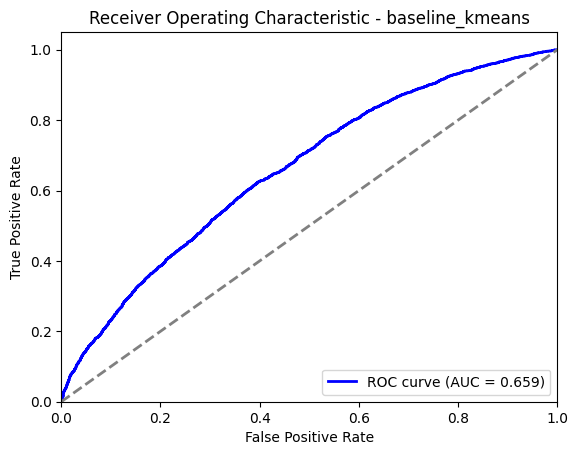

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.612,0.628074,0.597466,0.612388,0.658743


In [771]:
evaluate_model(y_proba_xgb,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [772]:
y_pred_xgb = xgb_model.predict(X_hold)
y_proba_xgb=xgb_model.predict_proba(X_hold)

Model Performance: 
    Accuracy = 59.854%
    Recall = 59.934%
    Precision = 2.9%
    F1 Score = 5.533%
    
AUC = 64.271%


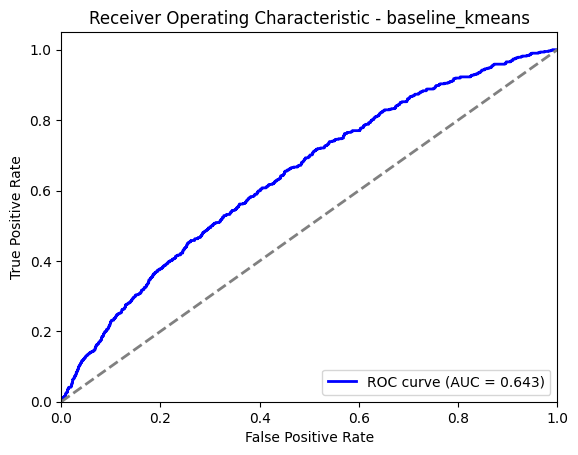

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.598544,0.599343,0.029003,0.055328,0.642707


In [773]:
evaluate_model(y_proba_xgb,y_hold,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [739]:
# Hyperparameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': np.linspace(0, 0.5, 5)
}

In [740]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of different combinations to try
    scoring=scoring,
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1,  # Use all available cores
    random_state=1973
)

In [741]:
# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1 Score from cross-validation: {random_search.best_score_}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1711111111111111, 'gamma': 0.125, 'colsample_bytree': 0.9}
Best F1 Score from cross-validation: nan


In [742]:
# Predict on the test set with the best found model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba=best_model.predict_proba(X_test)

# Calculate F1 Score on the test set
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test F1 Score: {test_f1}")

Test F1 Score: 0.6207075233203732


Model Performance: 
    Accuracy = 62.075%
    Recall = 64.011%
    Precision = 60.538%
    F1 Score = 62.226%
    
AUC = 66.737%


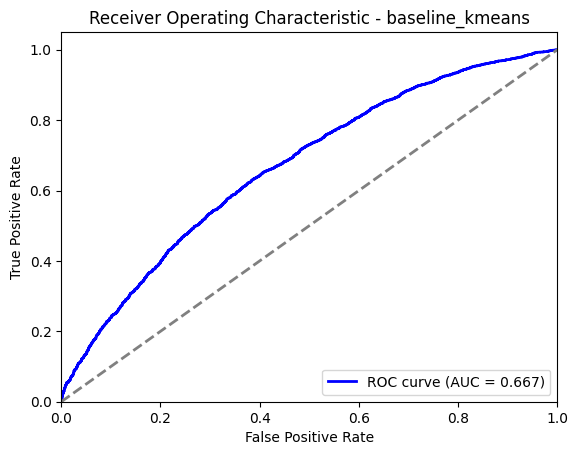

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.62075,0.640113,0.605378,0.622261,0.667372


In [743]:
evaluate_model(y_pred_proba,y_test,ret_df=True,plot_roc=True,name='baseline_kmeans')

In [744]:
y_pred = best_model.predict(X_hold)
y_pred_proba=best_model.predict_proba(X_hold)

Model Performance: 
    Accuracy = 60.344%
    Recall = 63.383%
    Precision = 3.094%
    F1 Score = 5.9%
    
AUC = 65.394%


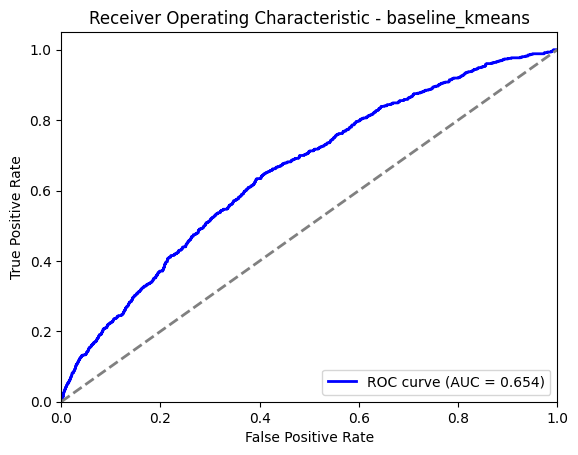

,model,Accuracy,Recall,Precision,F1 Score,AUC
0,baseline_kmeans,0.60344,0.633826,0.030942,0.059003,0.653942


In [745]:
evaluate_model(y_pred_proba,y_hold,ret_df=True,plot_roc=True,name='baseline_kmeans')

## Linear Regrssion model

In [ ]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
y_proba_lr = model_lr.predict_proba(X_test)

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Performance: 
    Accuracy = 56.912%
    Recall = 59.042%
    Precision = 55.502%
    F1 Score = 57.217%
    
AUC = 59.463%


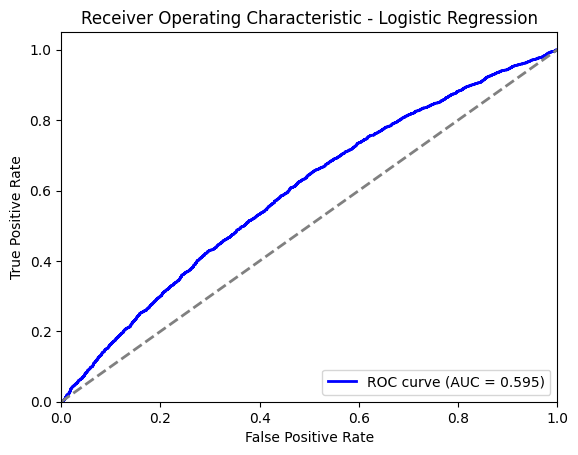

In [ ]:
evaluate_model(y_proba_lr, y_test, name='Logistic Regression', plot_roc=True, ret_df=False)

In [ ]:
proba=model_lr.predict_proba(X_test)

In [694]:

def test_thresh(x,y_test):
    threshold_value=[]
    scores_acc=[]
    scores_f1=[]
    scores_rec=[]
    scores_prec=[]
    for i in np.linspace(0, 1, 101):
        threshold = i  # You can adjust the threshold as needed
        y_pred_fun = (x[:, 1] > threshold).astype(int)
        threshold_value.append(i)
        scores_acc.append(accuracy_score(y_test, y_pred_fun))
        scores_f1.append(f1_score(y_test, y_pred_fun))
        scores_rec.append(recall_score(y_test, y_pred_fun))
        scores_prec.append(precision_score(y_test, y_pred_fun))
        #scores_roc.append(roc_auc_score(y_test, y_prob))
    return pd.DataFrame({'threshold_value':threshold_value,'score_acc':scores_acc,'score_f1':scores_f1,'score_rec':scores_rec,'score_prec':scores_prec}).set_index('threshold_value')

C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\xtaym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill

<Axes: xlabel='threshold_value'>

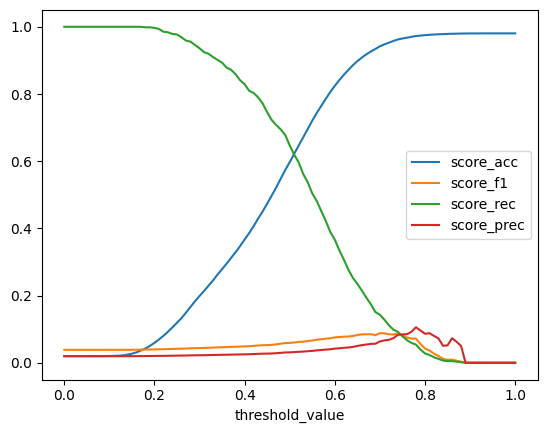

In [697]:
test_thresh(y_pred_proba,y_hold).plot()

In [698]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [703]:
# precision, recall, _ = precision_recall_curve(y_hold, y_pred_proba[:,1])
# average_precision = average_precision_score(y_hold, y_pred_proba[:,1])

In [715]:
precision, recall, _ = precision_recall_curve(y_test, y_proba_lr[:,1])
average_precision = average_precision_score(y_test, y_proba_lr[:,1])

In [718]:
precision

array([0.488     , 0.48806101, 0.48812203, ..., 0.5       , 1.        ,
       1.        ])

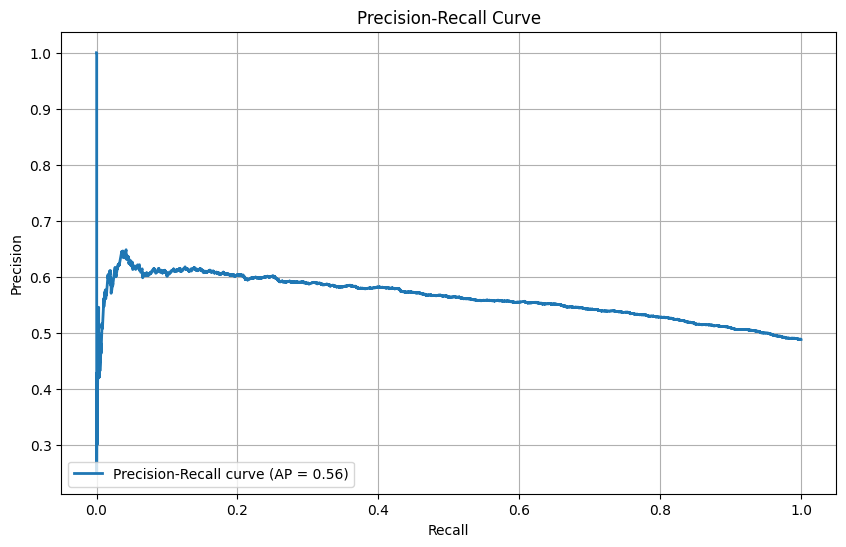

In [716]:
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {average_precision:.2f})', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()